# Plotting sea ice in the Southern Ocean
This script produces plots of sea ice area around the Southern Ocean using outputs from ACCESS-OM2-01.  
**Requirements:** It is suggested you use the `conda/analysis3-20.01` (or later) kernel. This can be defined using the drop down list on the left hand corner, or type `!module load conda/analysis3` in a Python cell.

## Loading relevant modules
These modules are used to access relevant outputs and to manipulate data. 

In [2]:
import cosima_cookbook as cc
import xarray as xr
import numpy as np
import pandas as pd
from dask.distributed import Client, progress
import os
from glob import glob
import re
from collections import OrderedDict
# from datetime import datetime
import calendar
#Importing script containing functions developed to calculate timeseries
import ZonalStatsFunctions as zsf
import netCDF4 as nc
import datetime as dt
import cftime
import xesmf as xe

The following modules are used in plotting maps and time series.

In [3]:
#Packages for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm                  
import cartopy.crs as ccrs            
import cartopy.feature as cft         
import matplotlib.gridspec as gridspec
import geopandas

#This first line will show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline

## Accessing model outputs
Start a cluster that has multiple cores to work with. Remember that the number of cores cannot exceed the number of CPUs requested when accessing GADI.  
If the line below does not run, skip it. The result is that the job will not be parallelised, but the script will still run.

In [4]:
client = Client(n_workers = 8)

Access the default database of experiments from where data will be loaded.

In [4]:
session = cc.database.create_session()

This notebook uses the outputs for the v140 run of ACCESS-OM2-01 which includes wind forcing. Includes experiments `01deg_jra55v140_iaf` and `01deg_jra55v140_iaf`. A list of experiments can be accessed using `cc.querying.get_experiments(session)`, you can get a detailed list of experiments by adding `all = True` argument.

## Set up variable dictionary prior ACCESS-OM2 model outputs
Once the correct experiment variables have been identified, data can be loaded into the notebook for further processing. All variables needed to do this are included below.

In [5]:
varDict =  {'var_id': 'aice_m',
            'model': 'ACCESS-OM2-01',
             'expt': '01deg_jra55v140_iaf_cycle2', # ACCESS-OM2-01 cycle 2
             'freq': '1 monthly',
             'start_date': range(1965, 2018, 1),
             'offset': np.nan,
             'long_name': 'sea ice area',
             'short_name': 'SIA',
             'unit': '$m^2$',
             'CICE_data': True,
             'base_data': r'/g/data/v45/la6889/Calculations/SeaIceArea/Data',
             'climatologies': r'/g/data/v45/la6889/Calculations/SeaIceArea/Climatologies',
             'clim_fig': r'/g/data/v45/la6889/Figures/SeaIceArea/Climatologies',
             'linear_trends': r'/g/data/v45/la6889/Calculations/SeaIceArea/LinearTrends',
             'lm_fig': r'/g/data/v45/la6889/Figures/SeaIceArea/LinearTrends',
             'clipped_data': r'/g/data/v45/la6889/Calculations/SeaIceArea/ClippedMEASOregions/',
             'weighted_means_season': r'/g/data/v45/la6889/Calculations/SeaIceArea/YearlySeasonal/Means',
             'weighted_means_monthly': r'/g/data/v45/la6889/Calculations/SeaIceArea/YearlyMonthly/Means',
             'weighted_std_monthly': r'/g/data/v45/la6889/Calculations/SeaIceArea/YearlyMonthly/StdDev',
             'decades': range(1965, 2019, 10),
             'weighted_means_dec_season': r'/g/data/v45/la6889/Calculations/SeaIceArea/DecadalSeasonal/Means',
             'weighted_means_dec_monthly': r'/g/data/v45/la6889/Calculations/SeaIceArea/DecadalMonthly/Means',
             'mean_sector_time_series': r'/g/data/v45/la6889/Figures/TimeSeries/SeaIceArea/PolarZones',
             'res': '0.1°'}

## Finding experiment variable names (Optional step)
You can query the temporal frequency of all variables available in the experiment using `cc.querying.get_frequencies(session, experiment)`. A list of experiment variables can be obtained using `cc.querying.get_variables(session, experiment, frequency)`.

In [1]:
#Activate the lines below to query temporal frequency
cc.querying.get_frequencies(session, varDict['expt'])

Query experiment variables list

In [11]:
#Querying experiment variables
expvar = cc.querying.get_variables(session, exp, frequency = "1 monthly")

#Extract variables with keywords included in its long_name column
expvar[expvar["long_name"].str.lower().str.match(".*ice.*")] #force all letters to be lowercase to get matches

name                                          long_name  \
5               Sinz_m                         ice internal bulk salinity   
8               Tinz_m             ice internal temperatures on CICE grid   
9               Tsfc_m                       snow/ice surface temperature   
12               VGRDi                                vertical ice levels   
14              aice_m                              ice area  (aggregate)   
15             aicen_m                               ice area, categories   
25             blkmask                                ice grid block mask   
29            congel_m                             congelation ice growth   
36          dvirdgdt_m                            ice volume ridging rate   
53            frazil_m                                  frazil ice growth   
54             fresh_m                      freshwtr flx ice to ocn (cpl)   
56          fsalt_ai_m                             salt flux ice to ocean   
57             fsalt_m                         salt flux ice to ocn (cpl)   
62                hi_m                       grid cell mean ice thickness   
64               lprec  liquid precip (including ice melt/form) into o...   
66                melt  water flux transferred with sea ice form/melt ...   
67             meltb_m                                     basal ice melt   
69             meltt_m                                       top ice melt   
70             mh_flux  heat into ocean due to melting ice (>0 heats o...   
96   sfc_salt_flux_ice                                  sfc_salt_flux_ice   
99            snoice_m                                 snow-ice formation   
102          strairx_m                                 atm/ice stress (x)   
103          strairy_m                                 atm/ice stress (y)   
104         strength_m                           compressive ice strength   
105          strocnx_m                               ocean/ice stress (x)   
106          strocny_m                               ocean/ice stress (y)   
137             uvel_m                                   ice velocity (x)   
141            vicen_m                             ice volume, categories   
142             vvel_m                                   ice velocity (y)   
143            wfiform  water out of ocean due to ice form (>0 enters ...   
144            wfimelt  water into ocean due to ice melt (>0 enters oc...   

     frequency                                             ncfile  # ncfiles  \
5    1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc         60   
8    1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc         60   
9    1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc        732   
12   1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc         60   
14   1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc        732   
15   1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc        732   
25   1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc        732   
29   1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc        732   
36   1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc        573   
53   1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc        732   
54   1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc        573   
56   1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc        732   
57   1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc        732   
62   1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc        732   
64   1 monthly  output487/ocean/ocean-2d-lprec-1-monthly-mean-...        244   
66   1 monthly  output487/ocean/ocean-2d-melt-1-monthly-mean-y...        244   
67   1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc        573   
69   1 monthly               output487/ice/OUTPUT/iceh.2018-12.nc        573   
70   1 monthly  output487/ocean/o

In [19]:
#Deleting variables no longer in use
del expvar

['2000-02', '2001-02', '2002-02', '2003-02', '2004-02', '2005-02', '2006-02', '2007-02', '2008-02', '2009-02', '2010-02', '2011-02', '2012-02', '2013-02', '2014-02', '2015-02', '2016-02', '2017-02', '2018-02'] ['2001-01', '2002-01', '2003-01', '2004-01', '2005-01', '2006-01', '2007-01', '2008-01', '2009-01', '2010-01', '2011-01', '2012-01', '2013-01', '2014-01', '2015-01', '2016-01', '2017-01', '2018-01', '2019-01']


## Accessing ACCESS-OM2 outputs and saving results to disk

In [49]:
dir_out = varDict['base_data']
os.makedirs(dir_out, exist_ok = True)

for yr in varDict['decades']:
    #Accessing data per decade
    stime = f'{str(yr)}-01'
    etime = f'{str(yr+9)}-12'
    #Accessing ACCESS 0.1deg outputs for the entire time range of interest
    SO = zsf.getACCESSdata(varDict['var_id'], stime, etime,
                           freq = varDict['freq'], 
                           ses = session, minlat = -80, maxlat = -35,
                           ice_data = True)
    #Correcting longitudes
    SO = zsf.corrlong(SO)
    #Creating name of file    
    fn = f'SeaIceConcentration_{str(yr)}-{str(yr+9)}.nc'
    #Saving file
    SO.to_netcdf(os.path.join(dir_out, fn))

### Loading longitude corrected sea ice concentration data from disk

In [25]:
#Get list of files in disk
filelist = sorted(glob(os.path.join(varDict['base_data'], '*Conc*.nc')))

#Empty list to store files
SIC = []

#Loading single files
for file in filelist:
    SIC.append(xr.open_dataarray(file))

#Concantenating all files into a single data array
SIC = xr.concat(SIC, dim = 'time')

## Calculating climatologies for variable of interest across the Southern Ocean
The satellite period (1979-2008) was chosen to calculate climatologies, and three climatologies were calculated:
- Overall, which includes the mean for the entire climatological period
- Seasonal, which is the mean value per season over the climatological period
- Monthly, which is the mean monthly value over the climatological period

Calculations are done in this way to avoid issues with memory.

In [75]:
clim_overall = zsf.climCalc(SIC, [1979, 2008], clim_type = 'overall', 
                            varname = varDict['short_name'],
                            folder_out = varDict['climatologies'])
clim_seasonal = zsf.climCalc(SIC, [1979, 2008], clim_type = 'seasonal', 
                             varname = varDict['short_name'],
                             folder_out = varDict['climatologies'])
clim_monthly = zsf.climCalc(SIC, [1979, 2008], clim_type = 'monthly', 
                            varname = varDict['short_name'],
                            folder_out = varDict['climatologies'])

## Loading climatologies and plotting them

### Overall Climatology

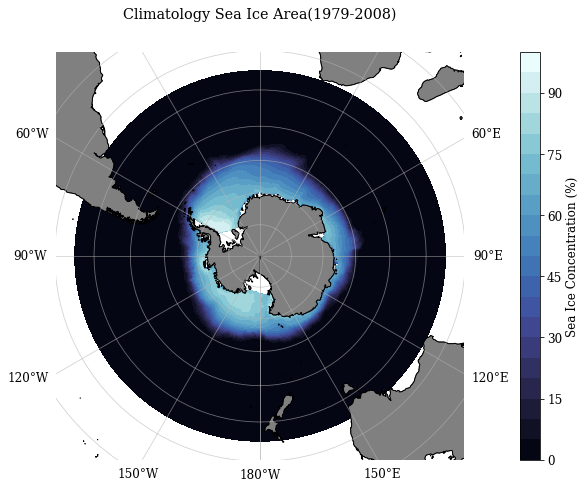

In [84]:
folder = os.path.join(varDict['climatologies'], '*overall*.nc')
fn = glob(folder)[0]

clim_overall = xr.open_dataarray(fn)*100

#Ensure folder where figures will be saved exists
folder_out = varDict['clim_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 7.5))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

levels = np.arange(0, 101, 5)

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', 
                                   linewidth = 0.5)

ax = fig.add_subplot(111, projection = projection)

#Add contour plot of sea ice advance
p = clim_overall.plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', levels = levels,
                                 ax = ax, cmap = cm.cm.ice, 
                                transform = ccrs.PlateCarree(), 
                                add_colorbar = False)

#Add land and coastlines
ax.add_feature(land_50m)
ax.coastlines(resolution = '50m')

#Apply colourbar to figure and set it to be horizontal
cb = fig.colorbar(p, ax = ax, label = 'Sea Ice Concentration (%)', pad = 0.1)

#Add title
ax.set_title('Climatology ' + varDict['long_name'].title() + '(1979-2008)')

#Draw gridlines
gl = ax.gridlines(draw_labels = True, y_inline = False, color = "#b4b4b4", alpha = 0.6)
#Locate longitude ticks - Set to every 30 deg
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
#Give longitude labels the correct format for longitudes
gl.xformatter = LONGITUDE_FORMATTER
#Set rotation of longitude labels to zero
gl.xlabel_style = {'rotation': 0}
#Set latitude labels to be transparent
gl.ylabel_style = {'alpha': 0}
#Add space between axis ticks and labels for x and y axes
gl.xpadding = 9
gl.ypadding = 9
gl.xlabels_left = False
gl.xlabels_right = True
gl.xlabels_top = False

#Remove the outside frame and ticklines of the figure
[s.set_visible(False) for s in ax.spines.values()]
[t.set_visible(False) for t in ax.get_xticklines()]
[t.set_visible(False) for t in ax.get_yticklines()]

fn = 'OverallClimatology_SeaIceConcentration_1979-2008.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

### Seasonal Climatology

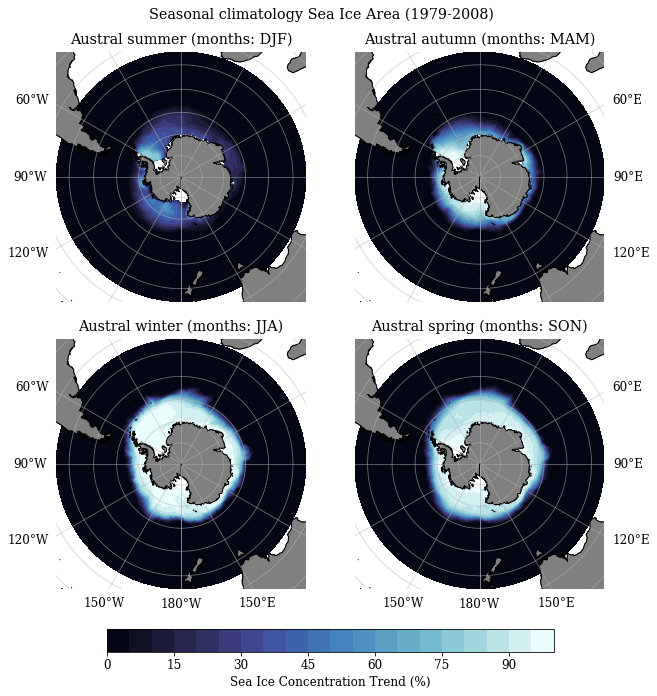

In [7]:
folder = os.path.join(varDict['climatologies'], '*seasonal*.nc')
fn = glob(folder)[0]

clim_seasonal = xr.open_dataarray(fn)*100

#Ensure folder where figures will be saved exists
folder_out = varDict['clim_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

levels = np.arange(0, 101, 5)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonName = {'DJF': 'Austral summer', 'MAM': 'Austral autumn', 
              'JJA': 'Austral winter', 'SON': 'Austral spring'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.15)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'DJF'), (0, 1, 'MAM'), (1, 0, 'JJA'), (1, 1, 'SON')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    #Extract information for each season and start plotting
    p1 = (clim_seasonal.sel(season = season)).\
    plot.contourf(x = 'xt_ocean', y = 'yt_ocean', ax = ax[season], 
                  cmap = cm.cm.ice, levels = levels,
                  #Remove colourbar to allow for further manipulation
                  transform = ccrs.PlateCarree(), add_colorbar = False)
        
    #Set title for each subplot.
    ax[season].set_title(seasonName[season] + ' (months: ' + season + ')', y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
        
    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 0 and j == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 1 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.8, pad = 0.06, 
                  label = 'Sea Ice Concentration Trend (%)')
    
fig.suptitle('Seasonal climatology ' + varDict['long_name'].title() + ' (1979-2008)', 
             y = 0.93)

fn = 'SeasonalClimatology_SeaIceConcentration_1979-2008.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

### Monthly Climatology

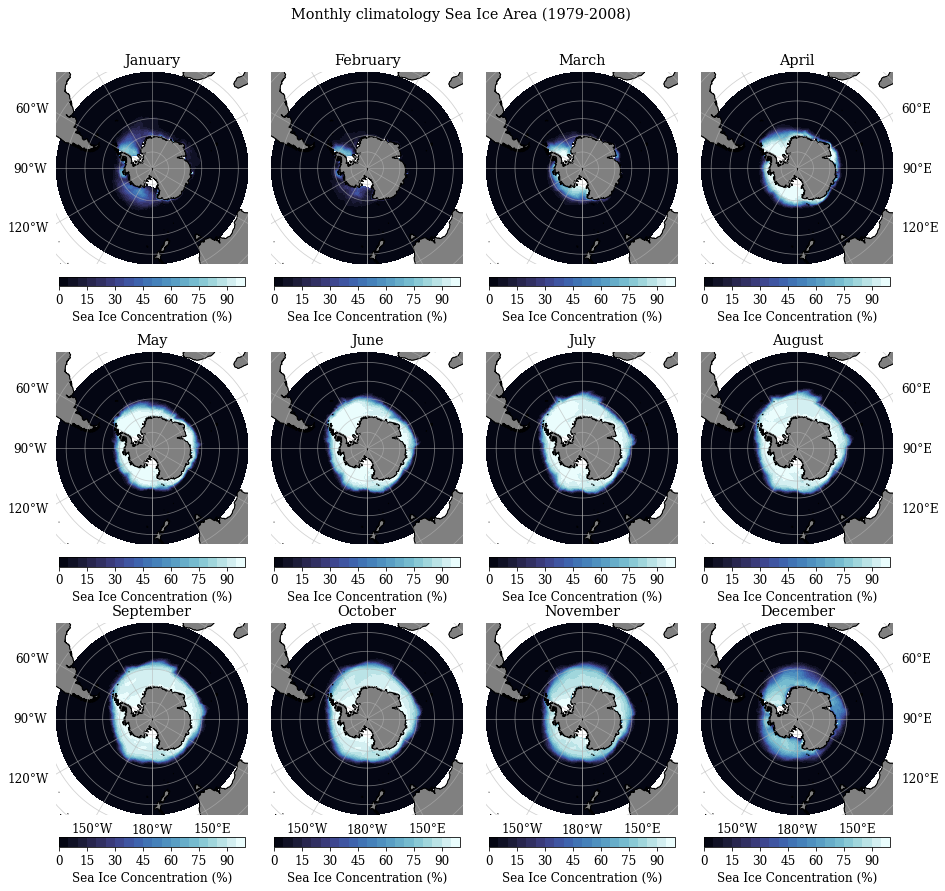

In [92]:
folder = os.path.join(varDict['climatologies'], '*month*.nc')
fn = glob(folder)[0]

clim_monthly = xr.open_dataarray(fn)*100

#Ensure folder where figures will be saved exists
folder_out = varDict['clim_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (15, 15))

levels = np.arange(0, 101, 5)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', 
                                   edgecolor = 'black', facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 3, ncols = 4)
#Change the width between each plot
gs.update(wspace = 0.12, hspace = 0.1)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for n, m in enumerate(clim_monthly.month.values):
    ax[m] = fig.add_subplot(gs[n], projection = projection)
    #Extract information for each season and start plotting
    p1 = (clim_monthly.sel(month = m)).\
    plot.contourf(x = 'xt_ocean', y = 'yt_ocean', ax = ax[m], 
                  cmap = cm.cm.ice, levels = levels,
                  #Remove colourbar to allow for further manipulation
                  transform = ccrs.PlateCarree(), add_colorbar = False)
        
    #Set title for each subplot.
    ax[m].set_title(calendar.month_name[m], y = 1.01)
    #Remove x and y axes labels
    ax[m].set_ylabel("")
    ax[m].set_xlabel("")
      
    #Add land and coastlines
    ax[m].add_feature(land_50m)
    ax[m].coastlines(resolution = '50m')
        
    #Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
    if n not in [8, 9, 10, 11]:
        cb = fig.colorbar(p1, ax = ax[m], orientation = 'horizontal', 
                          shrink = 0.97, pad = 0.05, 
                          label = 'Sea Ice Concentration (%)')
    else:
        cb = fig.colorbar(p1, ax = ax[m], orientation = 'horizontal', 
                          shrink = 0.97, pad = 0.09, 
                          label = 'Sea Ice Concentration (%)')

    #Draw gridlines
    gl = ax[m].gridlines(draw_labels = True, y_inline = False, 
                         color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    gl.xlabels_left = False
    gl.xlabels_right = False
    gl.xlabels_top = False
    gl.xlabels_bottom = False
    gl.ylabels_right = False
    gl.ylabels_left = False
    if n in [0, 4]:
        gl.ylabels_left = True
    elif n in [3, 7]:
        gl.ylabels_right = True
    elif n == 8:
        gl.ylabels_left = True
        gl.xlabels_bottom = True
    elif n in [9, 10]:
        gl.xlabels_bottom = True
    elif n == 11:
        gl.ylabels_right = True
        gl.xlabels_bottom = True
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[m].spines.values()]
    [t.set_visible(False) for t in ax[m].get_xticklines()]
    [t.set_visible(False) for t in ax[m].get_yticklines()]

fig.suptitle('Monthly climatology ' + varDict['long_name'].title() + ' (1979-2008)', 
             y = 0.93)

fn = 'MonthlyClimatology_SeaIceConcentration_1979-2008.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

## Calculating linear trends in sea ice seasonality

### Defining seasons

In [6]:
seasonName = {'Summer': [12, 1, 2], 'Autumn': [3, 4, 5], 
              'Winter': [6, 7, 8], 'Spring': [9, 10, 11]}

### Separating data into seasons

In [ ]:
climdata = SIC.sel(time = slice('1978-12', '2008-11'))

seasons_SIC = {}

for season in seasonName.keys():
    y = []
    for i, m in enumerate(climdata.time.dt.month.values.tolist()):
        if m in seasonName[season]:
            y.append(climdata[i])
    seasons_SIC[season] = xr.concat(y, dim = 'time')

### Calculating linear trends per season

In [78]:
#Folder where linear trends will be saved
dir_out = varDict['linear_trends']
#Ensure directory exists prior to saving results
os.makedirs(dir_out, exist_ok = True)

#Calculating linear trend for each season
for season in seasonName:
    #Define file name
    fn = f'LinearTrend_SIC_{season}_1979-2008.nc'

    #Extracting years to calculate linear trends
    time_ind = np.arange(0, len(seasons_SIC[season].time))
    #Extract values from SIC data and create a vector
    vals = seasons_SIC[season].values.reshape(len(time_ind), -1)

    #Save coefficients and pvalues for linear regression calculations
    slope, intercept, r, p, se = np.apply_along_axis(zsf.lm_yr, 0, vals, x = time_ind)

    #Reshaping coefficients and pvalues to original dimensions of the data array
    coef_r = xr.DataArray(data = slope.reshape(seasons_SIC[season][0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = seasons_SIC[season].xt_ocean.values, 
                                        yt_ocean = seasons_SIC[season].yt_ocean.values),
                          name = "coefficients")

    pval_r = xr.DataArray(data = p.reshape(seasons_SIC[season][0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = seasons_SIC[season].xt_ocean.values, 
                                        yt_ocean = seasons_SIC[season].yt_ocean.values),
                          name = "p_values")

    LM_results = xr.merge([coef_r, pval_r])

    #Saving outputs
    LM_results.to_netcdf(os.path.join(dir_out, fn))

### Loading linear trends to avoid recalculating

In [148]:
filelist = glob(os.path.join(varDict['linear_trends'], '*.nc'))

LM_results = {}

for season in seasonName:
    file = [file for file in filelist if season in file]
    LM_results[season] = xr.open_dataset(file[0])

### Loading MEASO regions to overlay them on plot

<AxesSubplot:>

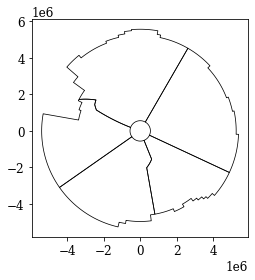

In [144]:
#Load shapefile
MEASO = geopandas.read_file('/g/data/v45/la6889/GIS_DataBase/Shapefiles/MEASO/measo.shp')

#Remove temperate zones as they are not within area of interest
MEASO = MEASO.query('zone != "Temperate"')

#Merge sectors within regions as sea ice is mostly within Antarctic areas
for i, sec in enumerate(np.unique(MEASO.sector)):
    pol = MEASO.query(f'sector == "{sec}"').geometry.unary_union
    pol_gs = geopandas.GeoSeries(pol).exterior
    if i == 0:
        MEASO_fixed = pol_gs
    else:
        MEASO_fixed = MEASO_fixed.append(pol_gs)

#Checking results
MEASO_fixed.plot()

### Plotting linear trends per season
Linear trends calculated from observations and model outputs are given in proportion per year. When plotting, data is multiplied by 1000 to transform units of linear trends to percentage per decade.

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '

  warnings.warn('The .ylabels_right attribute is deprecated. Please '

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '

  warnings.warn('The .ylabels_left attribute is deprecated. Please '

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .ylabels_right attribute is deprecated. Please '

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .ylabels_left attribute is deprecated. Please '



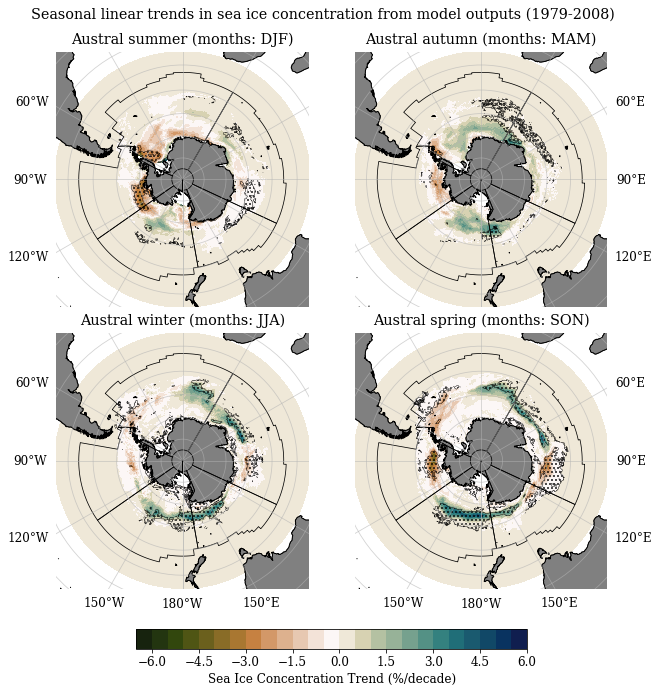

In [155]:
#Ensure folder where figures will be saved exists
folder_out = varDict['lm_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

levels = np.arange(-6.5, 6.1, 0.5)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonName = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.1)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'Summer'), (0, 1, 'Autumn'), 
                     (1, 0, 'Winter'), (1, 1, 'Spring')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    #Extract information for each season and start plotting
    data = LM_results[season].coefficients*1000
    #Multiplying by 1000 to get percentages per decade
    p1 = data.plot.pcolormesh(ax = ax[season], cmap = cm.cm.tarn, 
                              transform = ccrs.PlateCarree(), levels = levels,
                             add_colorbar = False)
    MEASO_fixed.plot(color = 'black', lw = 0.75, ax = ax[season])
    #Plotting significance
    #Extracting only significant values >= 0.05
    sig = xr.where(LM_results[season].p_values <= 0.05, True, 0)
    #Add contour around significant areas
    sig.plot.contour(colors = 'black', transform = ccrs.PlateCarree(),
                     ax = ax[season], add_colorbar = False, linewidths = .1)
    #Adding hatching
    sig.where(sig == 1, np.nan).plot.contourf(hatches = ['...'],
                                              colors = 'none', ax = ax[season],
                                              transform = ccrs.PlateCarree(), 
                                              add_colorbar = False)

    #Set title for each subplot.
    ax[season].set_title(seasonName[season], y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
    
    #Set map extent
    ax[season].set_extent([-180, 180, -90, -35], crs = ccrs.PlateCarree())

    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 0 and j == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 1 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.7, pad = 0.06, 
                  label = 'Sea Ice Concentration Trend (%/decade)')
fig.suptitle('Seasonal linear trends in sea ice concentration from model outputs (1979-2008)', 
             y = 0.93)

fn = 'SeasonalLinearTrends_SeaIceConcentration_1979-2008.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

### Calculating linear trends from observations

In [109]:
#Location of observation files
filelist = sorted(glob('/g/data/v45/la6889/Observations/*.nc'))

#Load them as data array
iceObs = []
for yr in range(1978, 2009):
    file = [f for f in filelist if str(yr) in f]
    data = xr.open_dataarray(file[0]).groupby('time.month').mean('time')
    time = pd.date_range(f'{yr}-{data.month.values.min()}', 
                         f'{yr}-{data.month.values.max()}', freq = 'MS')
    data = data.rename({'month': 'time'})
    data['time'] = time
    iceObs.append(data)
iceObs = xr.concat(iceObs, dim = 'time').sel(time = slice('1978-12', '2008-11'))

#Divide them into seasons
seasons_SIC_obs = {}
for season in seasonName.keys():
    y = []
    for i, m in enumerate(iceObs.time.dt.month.values.tolist()):
        if m in seasonName[season]:
            y.append(iceObs[i])
    seasons_SIC_obs[season] = xr.concat(y, dim = 'time')

In [13]:
#Folder where linear trends will be saved
dir_out = os.path.join(varDict['linear_trends'], 'Observations')
#Ensure directory exists prior to saving results
os.makedirs(dir_out, exist_ok = True)

#Calculating linear trend for each season
for season in seasonName:
    #Define file name
    fn = f'LinearTrend_SIC_obs_{season}_1979-2008.nc'

    #Extracting years to calculate linear trends
    time_ind = np.arange(0, len(seasons_SIC_obs[season].time))
    #Extract values from SIC data and create a vector
    vals = seasons_SIC_obs[season].values.reshape(len(time_ind), -1)

    #Save coefficients and pvalues for linear regression calculations
    slope, intercept, r, p, se = np.apply_along_axis(zsf.lm_yr, 0, vals, x = time_ind)

    #Reshaping coefficients and pvalues to original dimensions of the data array
    coef_r = xr.DataArray(data = slope.reshape(seasons_SIC_obs[season][0].shape), 
                          dims = ["ygrid", "xgrid"], 
                          coords = dict(xgrid = seasons_SIC_obs[season].xgrid.values, 
                                        ygrid = seasons_SIC_obs[season].ygrid.values),
                          name = "coefficients")

    pval_r = xr.DataArray(data = p.reshape(seasons_SIC_obs[season][0].shape), 
                          dims = ["ygrid", "xgrid"], 
                          coords = dict(xgrid = seasons_SIC_obs[season].xgrid.values, 
                                        ygrid = seasons_SIC_obs[season].ygrid.values),
                          name = "p_values")

    LM_results = xr.merge([coef_r, pval_r])

    #Saving outputs
    LM_results.to_netcdf(os.path.join(dir_out, fn))

### Loading linear trends from observations from disk to avoid recalculation

In [32]:
filelist = glob(os.path.join(varDict['linear_trends'], 'Observations/*.nc'))

LM_results_obs = {}

for season in seasonName:
    file = [file for file in filelist if season in file]
    LM_results_obs[season] = xr.open_dataset(file[0])
    LM_results_obs[season] = LM_results_obs[season].rename({'xgrid': 'x', 'ygrid': 'y'})

### Plotting linear trends from observations
Linear trends calculated from observations and model outputs are given in proportion per year. When plotting, data is multiplied by 1000 to transform units of linear trends to percentage per decade.

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '

  warnings.warn('The .ylabels_right attribute is deprecated. Please '

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '

  warnings.warn('The .ylabels_left attribute is deprecated. Please '

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .ylabels_right attribute is deprecated. Please '

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .ylabels_left attribute is deprecated. Please '



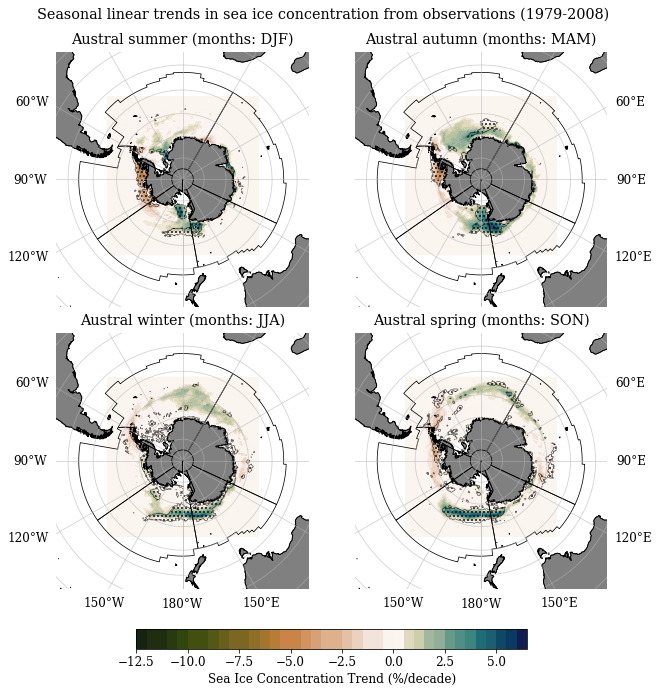

In [168]:
#Ensure folder where figures will be saved exists
folder_out = os.path.join(varDict['lm_fig'], 'Observations')
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

levels = np.arange(-12.5, 6.6, 0.5)

divnorm = mcolors.TwoSlopeNorm(vmin = -12.5, vcenter = 0, vmax = 6.5)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonName = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', 
                                   edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.1)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'Summer'), (0, 1, 'Autumn'), 
                     (1, 0, 'Winter'), (1, 1, 'Spring')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    #Extract information for each season and start plotting
    data = LM_results_obs[season].coefficients*1000
    #Multiplying by 1000 to get percentages per decade
    p1 = data.plot.pcolormesh(ax = ax[season], cmap = cm.cm.tarn, norm = divnorm,
                              levels = levels, add_colorbar = False)
    MEASO_fixed.plot(color = 'black', lw = 0.75, ax = ax[season])
    #Plotting significance
    #Extracting only significant values >= 0.05
    sig = xr.where(LM_results_obs[season].p_values <= 0.05, True, 0)
    #Add contour around significant areas
    sig.plot.contour(colors = 'black',
                     ax = ax[season], add_colorbar = False, linewidths = .1)
    #Adding hatching
    sig.where(sig == 1, np.nan).plot.contourf(hatches = ['...'],
                                              colors = 'none', ax = ax[season],
                                              add_colorbar = False)

    #Set title for each subplot.
    ax[season].set_title(seasonName[season], y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
    
    #Set map extent
    ax[season].set_extent([-180, 180, -90, -35], crs = ccrs.PlateCarree())

    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 0 and j == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 1 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.7, pad = 0.06, 
                  label = 'Sea Ice Concentration Trend (%/decade)')
fig.suptitle('Seasonal linear trends in sea ice concentration from observations (1979-2008)', 
             y = 0.93)

fn = 'SeasonalLinearTrends_Obs_SeaIceConcentration_1979-2008.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

## Comparing linear trends from observations and model outputs
Linear trends calculated from observations and model outputs are given in proportion per year. When plotting, data is multiplied by 1000 to transform units of linear trends to percentage per decade.

### Reprojecting model outputs to observation CRS

In [33]:
#Empty dictionary that will hold reprojected observations data
LM_obs_reproj = {}
LM_mod = {}

for key in LM_results_obs:
    obs = LM_results_obs[key].coefficients
    LM_obs_reproj[key] = zsf.reproject_latlon_coords(obs, 'epsg:3976', 'epsg:4326')
    mod = LM_results[key].coefficients.sel(yt_ocean = slice(-90, -50))
    LM_mod[key] = mod.rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'})

### Regridding of model outputs to match observations (coarsening data) and calculating trend differences
When plotting the regridded model outputs, the y axis must be inverted for the map to show the right way up. This can be done by adding the following line after plotting: `plt.gca().invert_yaxis()`.

In [35]:
#Ensuring folder to save regridded data exists
folder_out = os.path.join(varDict['linear_trends'], 'Regridded')
os.makedirs(folder_out, exist_ok = True)

#Regridder only calculated once as the same will be applied for all seasons
reg_coarse = xe.Regridder(LM_mod[key], LM_obs_reproj[key], 'bilinear')

#Empty dictionary that will hold reprojected observations data
LM_dif_obs_mod = {}
LM_dirdif_obs_mod = {}

for key in LM_mod:
    #Regridding model data
    mod_c = reg_coarse(LM_mod[key])
    #Saving regridded data
    fn = f'LinearTrend_SIC_regridded-mod_{key}_1979-2008.nc'
    mod_c.to_netcdf(os.path.join(folder_out, fn))
    #Calculating differences
    LM_dif_obs_mod[key] = LM_results_obs[key].coefficients - mod_c
    #Saving differences (obs - mod)
    fn_magdif = f'DifMag_LinearTrend_SIC_obs-mod_{key}_1979-2008.nc'
    LM_dif_obs_mod[key].to_netcdf(os.path.join(folder_out, fn_magdif))
    
    #Calculating differences in direction
    #Observations
    obs_dir = xr.where(LM_results_obs[key].coefficients > 0, 1, -1)
    obs_dir = xr.where(LM_results_obs[key].coefficients == 0, 0, obs_dir)
    obs_dir = xr.where(np.isnan(LM_results_obs[key].coefficients), np.nan, obs_dir)
    #Model outputs
    mod_dir = xr.where(mod_c > 0, 1, -1)
    mod_dir = xr.where(mod_c == 0, 0, mod_dir)
    mod_dir = xr.where(np.isnan(mod_c), np.nan, mod_dir)
    #Difference in direction
    LM_dirdif_obs_mod[key] = obs_dir-mod_dir
    #Saving results
    fn_dirdif = f'DifDir_LinearTrend_SIC_obs-mod_{key}_1979-2008.nc'
    LM_dirdif_obs_mod[key].to_netcdf(os.path.join(folder_out, fn_dirdif))

#### Loading differences from disk to avoid recalculation

In [36]:
#Getting files of magnitude and direction differences
filesDirDif = sorted(glob(os.path.join(varDict['linear_trends'], 'Regridded/DifDir*.nc')))
filesMagDif = sorted(glob(os.path.join(varDict['linear_trends'], 'Regridded/DifMag*.nc')))

#Empty dictionary that will hold reprojected observations data
LM_dif_obs_mod = {}
LM_dirdif_obs_mod = {}

for season in seasonName:
    fileDir = [fd for fd in filesDirDif if season in fd]
    fileMag = [fm for fm in filesMagDif if season in fm]
    LM_dif_obs_mod[season] = xr.open_dataarray(fileMag[0])
    LM_dirdif_obs_mod[season] = xr.open_dataarray(fileDir[0])

### Plotting differences between observations and model outputs

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '

  warnings.warn('The .ylabels_right attribute is deprecated. Please '

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '

  warnings.warn('The .ylabels_left attribute is deprecated. Please '

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .ylabels_right attribute is deprecated. Please '

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .ylabels_left attribute is deprecated. Please '



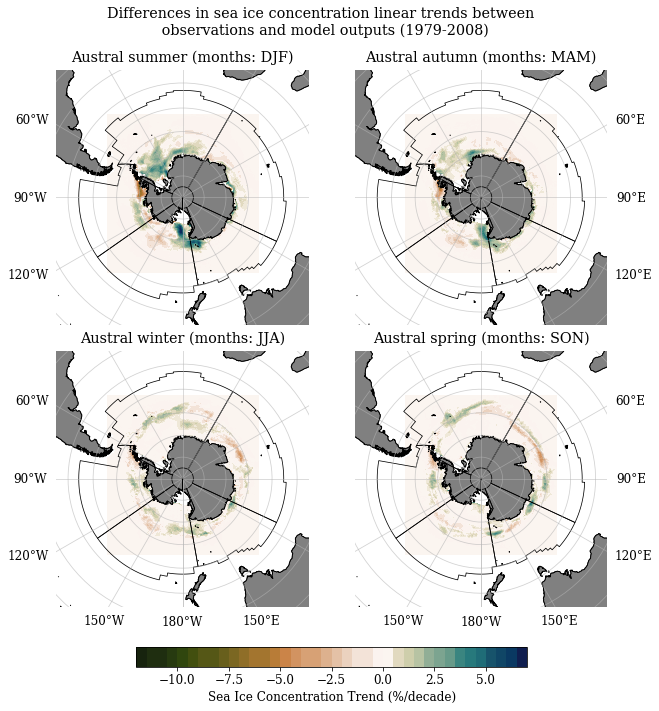

In [169]:
#Ensure folder where figures will be saved exists
folder_out = varDict['lm_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

levels = np.arange(-12, 7.1, 0.5)

divnorm = mcolors.TwoSlopeNorm(vmin = -12, vcenter = 0, vmax = 7)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonName = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', 
                                   edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.1)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'Summer'), (0, 1, 'Autumn'), 
                     (1, 0, 'Winter'), (1, 1, 'Spring')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    #Extract information for each season and start plotting
    data = LM_dif_obs_mod[season]*1000
    #Multiplying by 1000 to get percentages per decade
    p1 = data.plot.pcolormesh(ax = ax[season], cmap = cm.cm.tarn, norm = divnorm,
                              levels = levels, add_colorbar = False)
    MEASO_fixed.plot(color = 'black', lw = 0.75, ax = ax[season])

    #Set title for each subplot.
    ax[season].set_title(seasonName[season], y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
    
    #Set map extent
    ax[season].set_extent([-180, 180, -90, -35], crs = ccrs.PlateCarree())

    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 0 and j == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 1 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.7, pad = 0.06, 
                  label = 'Sea Ice Concentration Trend (%/decade)')
fig.suptitle('Differences in sea ice concentration linear trends between \n observations and model outputs (1979-2008)', 
             y = 0.95)

fn = 'Diffs_Obs-Mod_SeasonalTrends_SeaIceConcentration_1979-2008.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '

  warnings.warn('The .ylabels_right attribute is deprecated. Please '

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '

  warnings.warn('The .ylabels_left attribute is deprecated. Please '

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .ylabels_right attribute is deprecated. Please '

  warnings.warn('The .xlabels_top attribute is deprecated. Please '

  warnings.warn('The .ylabels_left attribute is deprecated. Please '



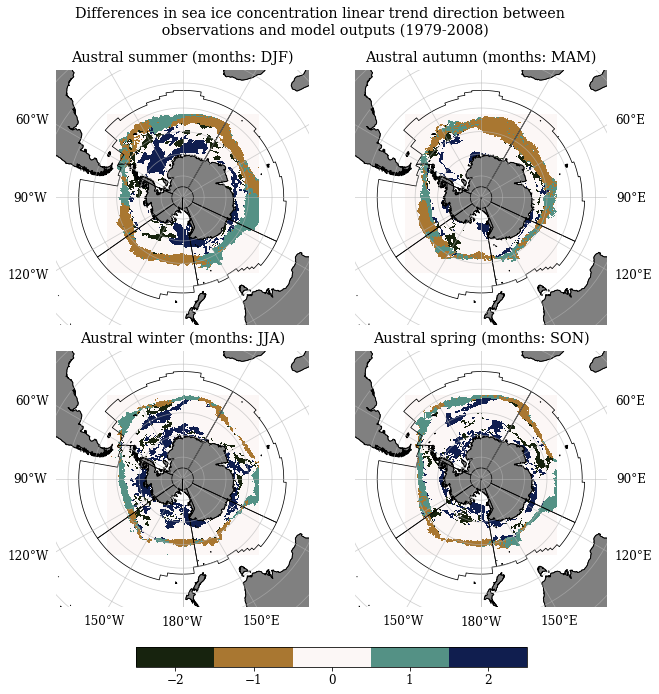

In [170]:
#Ensure folder where figures will be saved exists
folder_out = varDict['lm_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonName = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', 
                                   edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)
########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.1)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'Summer'), (0, 1, 'Autumn'), 
                     (1, 0, 'Winter'), (1, 1, 'Spring')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    #Extract information for each season and start plotting
    data = LM_dirdif_obs_mod[season]
    #Creating a colorbar from 'tarn' that contains five levels
    cmap = plt.get_cmap(cm.cm.tarn, 5)
    #Multiplying by 1000 to get percentages per decade
    p1 = data.plot.pcolormesh(ax = ax[season], cmap = cmap, 
                              #Levels and limits are 0.5 units wider than 
                              #actual measurements
                              levels = np.arange(-2.5, 2.6, 1),
                              vmin = -2.5, vmax = 2.5,
                              add_colorbar = False)
    MEASO_fixed.plot(color = 'black', lw = 0.75, ax = ax[season])

    #Set title for each subplot.
    ax[season].set_title(seasonName[season], y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
    
    #Set map extent
    ax[season].set_extent([-180, 180, -90, -35], crs = ccrs.PlateCarree())

    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    if i == 0 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
    elif i == 0 and j == 1:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_left = False
    elif i == 1 and j == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_right = False
    else:
        gl.xlabels_left = False
        gl.xlabels_right = True
        gl.xlabels_top = False
        gl.ylabels_left = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.7, pad = 0.06, 
                  #Ticks in colorbar match the data range
                  ticks = np.arange(-2, 2.1),
                  label = '')
fig.suptitle('Differences in sea ice concentration linear trend direction between \n observations and model outputs (1979-2008)', 
             y = 0.95)

fn = 'DirDiffs_Obs-Mod_SeasonalTrends_SeaIceConcentration_1979-2008.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

## Calculating Sea Ice Extent
Sea ice extent is calculated based on Hobbs et al 2016, which is the total area covered where sea ice concentration is 15% or more.

In [40]:
#Loading ice area data (in m2) - Only one file needed as they will be the same regardless of the time
IceArea = xr.open_dataarray('/g/data/v45/la6889/Calculations/Area_per_pixel_01deg/area_per_pixel_01deg_all_areas.nc')

In [35]:
#Ensure output folder exists
folder_out = varDict['base_data']
os.makedirs(folder_out, exist_ok = True)

#Only keep area pixels where sea ice concentration is 15% or more
SIE = xr.where(SIC >= 0.15, IceArea, np.nan)

#Save sea ice extent
fn = f'SeaIceExtent_{SIE.time.dt.year.values.min()}-{SIE.time.dt.year.values.max()}.nc'
SIE.to_netcdf(os.path.join(folder_out, fn))

### Loading sea ice extent to avoid recalculation

In [5]:
SIE = xr.open_dataarray(glob(os.path.join(varDict['base_data'], '*Ext*.nc'))[0])

## Splitting data into MEASO regions

In [7]:
#Defining sector names in order
sectorNames = ['East Pacific', 'Atlantic', 'Central Indian', 'East Indian', 'West Pacific']

In [ ]:
#Loading mask
regions = xr.load_dataarray('MEASO_SIS_3Dmask.nc')

#Subsetting shapefiles into regions - Initialise dictionary that will contain sector limits
MEASOregions = {}

#Saving each sector as an entry in the dictionary
for i in sectorNames:
    MEASOregions[f"{i}"] = regions.sel(region = i)
    
MEASOregions.keys()

In [21]:
#Ensuring output folder exists
out_folder = varDict['clipped_data']
#Ensuring file exists
os.makedirs(out_folder, exist_ok = True)

#Subsetting shapefiles into sectors - Initialise dictionary that will contain sector limits
clipped_SIE = {}

#Range of years included in data
minY = SIE.time.dt.year.values.min()
maxY = SIE.time.dt.year.values.max()

#Saving each sector as an entry in the dictionary
for sector in sectorNames:
    clip = []
    for t in SIE.time.values:
        sie_t = SIE.sel(time = t)
        sie_t = (sie_t*MEASOregions[sector]).sum(('xt_ocean', 'yt_ocean'))
        clip.append(sie_t)
    clipped_SIE[sector] = xr.concat(clip, dim = 'time')
    #Create name for output file
    fn = f'SeaIceExtent_{sector}_{minY}-{maxY}.nc'
    clipped_SIE[sector].to_netcdf(os.path.join(out_folder, fn))

## Splitting data into regions and seasons

In [10]:
seasonName = {'Summer': [12, 1, 2], 'Autumn': [3, 4, 5], 
              'Winter': [6, 7, 8], 'Spring': [9, 10, 11]}

In [39]:
#Ensuring output folder exists
out_folder = os.path.join(varDict['clipped_data'], 'Seasons')
#Ensuring file exists
os.makedirs(out_folder, exist_ok = True)

#Create empty list to hold data split into seasons and regions
seasons_SIE = {}

# clipped_SIE['Atlantic'].plot(col = 'time.season')
for sec in clipped_SIE:
    #Range of years included in data
    minY = clipped_SIE[sec].time.dt.year.values.min()
    maxY = clipped_SIE[sec].time.dt.year.values.max()
    for sea in seasonName:
        data = []
        for i, m in enumerate(clipped_SIE[sec].time.dt.month.values.tolist()):
            if m in seasonName[sea]:
                data.append(clipped_SIE[sec][i])
        seasons_SIE[f'{sec}_{sea}'] = xr.concat(data, dim = 'time')
        fn = f'SeaIceExtent_{sec}_{sea}_{minY}-{maxY}.nc'
        seasons_SIE[f'{sec}_{sea}'].to_netcdf(os.path.join(out_folder, fn))

### Loading data from disk to avoid recalculation

In [9]:
#Get a list of files with clipped data per sector and season
in_files = sorted(glob(os.path.join(varDict['clipped_data'], 'Seasons/*.nc')))

#Create empty list to hold data split into seasons and regions
seasons_SIE = {}

for sec in sectorNames:
    files = [file for file in in_files if sec in file]
    for sea in seasonName:
        file = [f for f in files if sea in f][0]
        seasons_SIE[f'{sec}_{sea}'] = xr.open_dataarray(file)

## Calculating trends over time

In [160]:
#Folder where linear trends will be saved
dir_out = os.path.join(varDict['linear_trends'], 'MEASO')
#Ensure directory exists prior to saving results
os.makedirs(dir_out, exist_ok = True)

#Creating empty dictionary to store linear regression results
LM_sea_sec = {}

#Calculating linear trend for each season
for key in seasons_SIE:
    #Extracting years to calculate linear trends
    time_ind = [i for i, j in enumerate(seasons_SIE[key].time)]
    #Extract values from SIC data and create a vector
    vals = seasons_SIE[key].values.tolist()

    #Save coefficients and pvalues for linear regression calculations
    slope, intercept, r, p, se = zsf.lm_yr(vals, time_ind)

    #Saving results in dictionary
    LM_sea_sec[key] = {'slope': slope,
                       'intercept': intercept,
                       'r': r,
                       'p': p,
                       'se': se}
    
#Saving outputs
#Define file name
    minY = seasons_SIE[key].time.dt.year.values.min()
    maxY = seasons_SIE[key].time.dt.year.values.max()
    fn = f'LinearTrends_SIE_AllSectors_{minY}-{maxY}.csv'

#Saving as csv
pd.DataFrame(LM_sea_sec).to_csv(os.path.join(dir_out, fn))

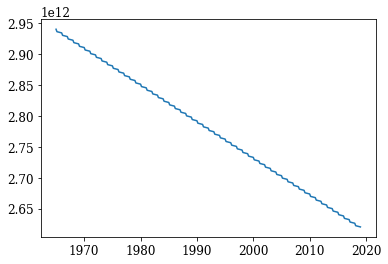

In [169]:
# time_ind = np.arange(0, len(seasons_SIE[f'Atlantic_{sea}'].time))
# time = seasons_SIE[f'Atlantic_{sea}'].time.values
# intercept = LM_sea_sec[f'Atlantic_{sea}']['intercept']
# slope = LM_sea_sec[f'Atlantic_{sea}']['slope']

# # print(len(intercept+(slope*time_ind)), len(time))
# # (slope*time_ind)
# # slope
plt.plot(time, intercept+(slope*time_ind))
# pd.DataFrame(LM_sea_sec)

In [223]:
pd.DataFrame(LM_sea_sec)

East Pacific_Summer  East Pacific_Autumn  East Pacific_Winter  \
slope             1.251354e+09        -1.095985e+09        -5.568189e+08   
intercept         7.215100e+11         1.136121e+12         2.219166e+12   
r                 1.060725e-01        -1.057350e-01        -8.452583e-02   
p                 1.777789e-01         1.805308e-01         2.848794e-01   
se                9.245011e+08         8.148628e+08         5.189285e+08   

           East Pacific_Spring  Atlantic_Summer  Atlantic_Autumn  \
slope            -1.202849e+09    -1.975964e+09     1.802333e+09   
intercept         2.170134e+12     2.940510e+12     2.885634e+12   
r                -1.625071e-01    -4.727929e-02     6.239397e-02   
p                 3.881753e-02     5.489652e-01     4.302494e-01   
se                5.773872e+08     3.290101e+09     2.279215e+09   

           Atlantic_Winter  Atlantic_Spring  Central Indian_Summer  \
slope        -2.410926e+09    -4.120112e+09           7.865790e+08   
intercept     6.818772e+12     7.212693e+12           7.727709e+11   
r            -1.648515e-01    -3.103357e-01           3.624968e-02   
p             3.605261e-02     5.843861e-05           6.459511e-01   
se            1.140376e+09     9.977630e+08           1.708991e+09   

           Central Indian_Autumn  Central Indian_Winter  \
slope               8.525846e+08          -5.938602e+08   
intercept           9.422775e+11           3.146009e+12   
r                   5.486614e-02          -6.394828e-02   
p                   4.880291e-01           4.188293e-01   
se                  1.226644e+09           7.326651e+08   

           Central Indian_Spring  East Indian_Summer  East Indian_Autumn  \
slope              -9.628149e+08       -1.011823e+08       -3.269521e+08   
intercept           3.642233e+12        3.283683e+11        6.766971e+11   
r                  -1.660661e-01       -1.307216e-02       -3.729829e-02   
p                   3.468673e-02        8.684585e-01        6.374853e-01   
se                  4.519904e+08        6.099681e+08        6.925209e+08   

           East Indian_Winter  East Indian_Spring  West Pacific_Summer  \
slope           -3.889387e+08       -1.020435e+09         2.964174e+09   
intercept        1.574901e+12        1.627037e+12         1.603930e+12   
r               -9.290907e-02       -1.880248e-01         1.316068e-01   
p                2.396238e-01        1.657311e-02         9.401200e-02   
se               3.295190e+08        4.213999e+08         1.759618e+09   

           West Pacific_Autumn  West Pacific_Winter  West Pacific_Spring  
slope             1.039602e+09        -1.492071e+08        -1.107502e+09  
intercept         2.299921e+12         3.745753e+12         3.912845e+12  
r                 6.963643e-02        -1.919312e-02        -1.192708e-01  
p                 3.785705e-01         8.084554e-01         1.306061e-01  
se                1.177375e+09         6.144746e+08         7.288514e+08

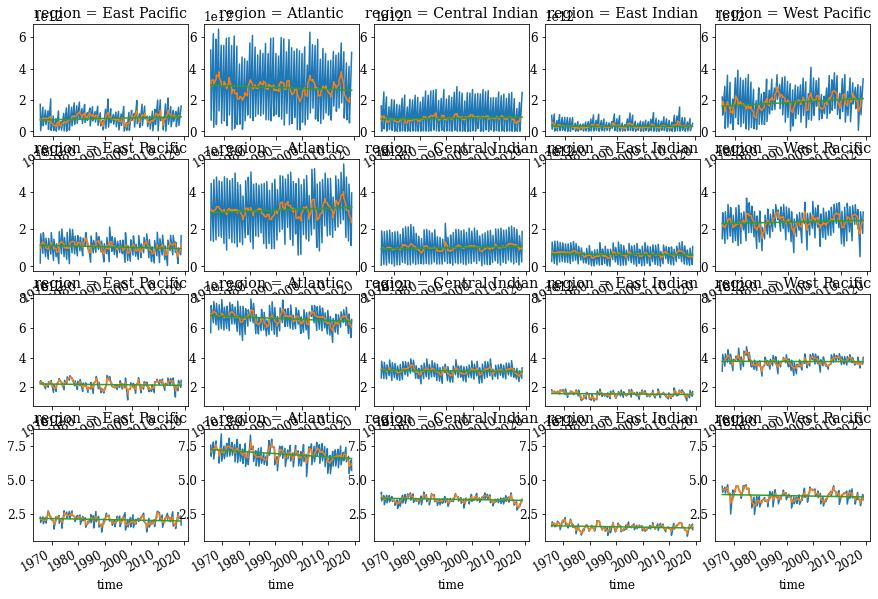

In [221]:
fig = plt.figure(figsize = (15, 12))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

gs = gridspec.GridSpec(nrows = len(sectorNames), ncols = 1)

for row, sea in enumerate(seasonName):
    axes = np.empty(shape = (1, len(sectorNames)), dtype = object)
    season = gridspec.GridSpecFromSubplotSpec(1, len(sectorNames),
                                              subplot_spec = gs[row], 
                                              wspace = 0.1)
    for col, sec in enumerate(sectorNames):
        ax = plt.Subplot(fig, season[0, col], sharey = axes[0, 0]) 
        fig.add_subplot(ax)
        axes[0, col] = ax
        seasons_SIE[f'{sec}_{sea}'].plot(ax = ax)
        seasons_SIE[f'{sec}_{sea}'].rolling(time = 3, center = True).mean().\
        plot(ax = ax)
    
        time_ind = np.arange(0, len(seasons_SIE[f'{sec}_{sea}'].time))
        time = seasons_SIE[f'{sec}_{sea}'].time
        intercept = LM_sea_sec[f'{sec}_{sea}']['intercept']
        slope = LM_sea_sec[f'{sec}_{sea}']['slope']
        plt.plot(time, intercept+(slope*time_ind))
        
        

# seasons_SIE['Atlantic_Autumn'].plot()
# seasons_SIE['Atlantic_Autumn'].rolling(time = 3, center = True).mean().plot()
# plt.plot(seasons_SIE['Atlantic_Autumn'].time, [intercept+(slope*t) for t in t_ind])
# print(slope*1e-6)

## Anomalies and extreme values

In [255]:
#Calculate climatological means and 90th percentile per sector and season
clim = {}
per90 = {}
per10 = {}

for key in seasons_SIE:
    clim[key] = seasons_SIE[key].sel(time = slice('1979', '2008')).groupby('time.month').mean()
    per90[key] = seasons_SIE[key].groupby('time.month').quantile(.9)
    per10[key] = seasons_SIE[key].groupby('time.month').quantile(.1)

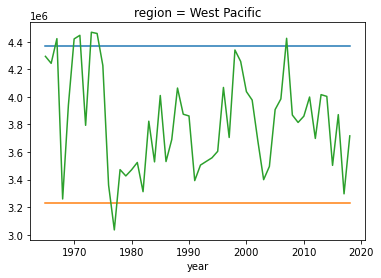

In [256]:
a = [(seasons_SIE[key].quantile(.9)*1e-6).values.tolist()]*int(len(seasons_SIE[key].time)/3)
b = [(seasons_SIE[key].quantile(.1)*1e-6).values.tolist()]*int(len(seasons_SIE[key].time)/3)
xr.DataArray(data = a, dims = 'time', coords = {'time': np.unique(seasons_SIE[key].time.dt.year.values)}).plot()
xr.DataArray(data = b, dims = 'time', coords = {'time': np.unique(seasons_SIE[key].time.dt.year.values)}).plot()
(seasons_SIE[key].groupby('time.year').mean()*1e-6).plot()

In [257]:
anom = seasons_SIE[key]-clim[key]
anom#.plot()

<xarray.DataArray (time: 162, month: 3)>
array([[ 5.72853313e+11,  7.03760459e+11,  9.83070362e+11],
       [ 3.40810019e+11,  4.71717165e+11,  7.51027068e+11],
       [ 1.40358863e+11,  2.71266009e+11,  5.50575912e+11],
       [ 5.01793385e+11,  6.32700531e+11,  9.12010434e+11],
       [ 3.23690590e+11,  4.54597736e+11,  7.33907639e+11],
       [ 7.66060323e+10,  2.07513178e+11,  4.86823081e+11],
       [ 6.73402384e+11,  8.04309530e+11,  1.08361943e+12],
       [ 6.74985783e+11,  8.05892929e+11,  1.08520283e+12],
       [ 9.06283238e+10,  2.21535470e+11,  5.00845373e+11],
       [ 3.43003341e+10,  1.65207480e+11,  4.44517383e+11],
       [-6.23052413e+11, -4.92145267e+11, -2.12835364e+11],
       [-1.45830001e+12, -1.32739286e+12, -1.04808296e+12],
       [ 2.98547867e+11,  4.29455013e+11,  7.08764916e+11],
       [-6.23207373e+10,  6.85864087e+10,  3.47896312e+11],
       [-2.46463136e+11, -1.15555990e+11,  1.63753913e+11],
       [ 3.76278154e+11,  5.07185300e+11,  7.86495202e+11],
       [ 4.71287537e+11,  6.02194683e+11,  8.81504586e+11],
       [ 5.85533141e+11,  7.16440287e+11,  9.95750190e+11],
       [ 5.72600607e+11,  7.03507753e+11,  9.82817655e+11],
       [ 5.81277703e+11,  7.12184849e+11,  9.91494752e+11],
...
       [-2.22937649e+11, -9.20305031e+10,  1.87279400e+11],
       [-7.28736933e+11, -5.97829787e+11, -3.18519884e+11],
       [ 2.48210386e+11,  3.79117532e+11,  6.58427435e+11],
       [ 2.90680517e+11,  4.21587663e+11,  7.00897566e+11],
       [-3.17333673e+11, -1.86426527e+11,  9.28833755e+10],
       [ 3.82083776e+11,  5.12990922e+11,  7.92300825e+11],
       [ 7.41533189e+10,  2.05060465e+11,  4.84370368e+11],
       [-2.72677780e+11, -1.41770634e+11,  1.37539269e+11],
       [-2.31216658e+11, -1.00309512e+11,  1.79000391e+11],
       [-3.55324953e+11, -2.24417807e+11,  5.48920955e+10],
       [-7.29811319e+11, -5.98904173e+11, -3.19594270e+11],
       [ 6.11078183e+10,  1.92014964e+11,  4.71324867e+11],
       [ 1.25136726e+11,  2.56043872e+11,  5.35353775e+11],
       [-3.99339455e+11, -2.68432309e+11,  1.08775937e+10],
       [-3.80980448e+11, -2.50073302e+11,  2.92366005e+10],
       [-7.09990113e+11, -5.79082967e+11, -2.99773065e+11],
       [-8.44229852e+11, -7.13322706e+11, -4.34012803e+11],
       [-2.11197681e+10,  1.09787378e+11,  3.89097281e+11],
       [-2.37454038e+11, -1.06546892e+11,  1.72763011e+11],
       [-4.16581555e+11, -2.85674409e+11, -6.36450622e+09]])
Coordinates:
  * time     (time) datetime64[ns] 1965-09-30T12:00:00 ... 2018-11-30T12:00:00
    region   <U12 'West Pacific'
  * month    (month) int64 9 10 11

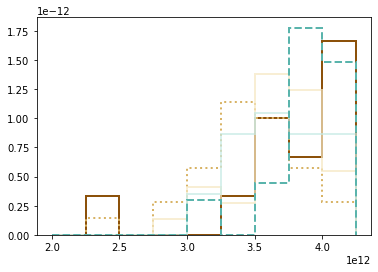

In [127]:
# t65_74 = seasons_SIE[key].sel(time = slice('1965', '1974'))
# t75_84 = seasons_SIE[key].sel(time = slice('1975', '1984'))
# t85_94 = seasons_SIE[key].sel(time = slice('1985', '1994'))
# t95_04 = seasons_SIE[key].sel(time = slice('1995', '2004'))
# t05_14 = seasons_SIE[key].sel(time = slice('2005', '2014'))

# rangeV = np.arange(seasons_SIE[key].values.min(), seasons_SIE[key].values.max(), 0.5e12)
bins = np.arange(2e12, 4.5e12, 0.25e12)

hist6070 = plt.hist(t65_74, bins = bins, density = True, histtype = 'step',
         color = '#8c510a', lw = 2)
hist7080 = plt.hist(t75_84, bins = bins, density = True, histtype = 'step', 
        color = '#d8b365', ls = ':', lw = 2)
hist8090 = plt.hist(t85_94, bins = bins, density = True, histtype = 'step', 
        color = '#f6e8c3', lw = 2, alpha = 0.7)
hist9000 = plt.hist(t95_04, bins = bins, density = True, histtype = 'step', 
        color = '#c7eae5', lw = 2, alpha = 0.7)
hist0010 = plt.hist(t05_14, bins = bins, density = True, histtype = 'step', 
        color = '#5ab4ac', lw = 2, ls = '--')

# minV = seasons_SIE[key].values.min()
# maxV = seasons_SIE[key].values.max()
# print(minV, maxV)

# from scipy import stats
# kernel = stats.gaussian_kde(seasons_SIE['Central Indian_Autumn'])
# Z = kernel(np.arange(minV, maxV+1))
# Z.plot()

In [137]:
# from scipy import stats
# stats.kstest(hist6070[0].tolist(), hist7080[0].tolist(), alternative = 'two-sided')
stats.kstest(hist6070[0].tolist(), hist8090[0].tolist(), alternative = 'two-sided')

KstestResult(statistic=0.1111111111111111, pvalue=1.0)

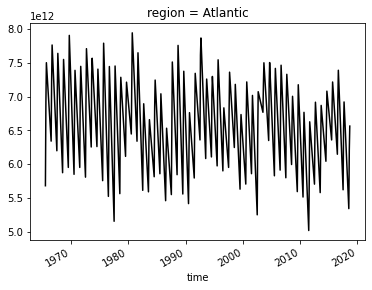

## Calculating linear trends by longitude

In [234]:
meanlon = SIE.sum('yt_ocean', skipna = True, min_count = 1)
meanlon = meanlon.fillna(0)

In [241]:
meanlon_clim = meanlon.sel(time = slice('1978-12', '2008-11'))

seasons_SIE = {}

for month in range(1, 13):
    y = []
    for i, m in enumerate(meanlon_clim.time.dt.month.values.tolist()):
        if month == m:
            y.append(meanlon_clim[i])
    seasons_SIE[calendar.month_abbr[month]] = xr.concat(y, dim = 'time')

In [242]:
#Folder where linear trends will be saved
dir_out = varDict['linear_trends']
#Ensure directory exists prior to saving results
os.makedirs(dir_out, exist_ok = True)

#Calculating linear trend for each season
for m in calendar.month_abbr[1:]:
    #Define file name
    fn = f'LinearTrend_SIC-lon_{m}_1979-2008.nc'

    #Extracting years to calculate linear trends
    time_ind = np.arange(0, len(seasons_SIE[m].time))
    #Extract values from SIC data and create a vector
    vals = seasons_SIE[m].values.reshape(len(time_ind), -1)

    #Save coefficients and pvalues for linear regression calculations
    slope, intercept, r, p, se = np.apply_along_axis(zsf.lm_yr, 0, vals, x = time_ind)

    #Reshaping coefficients and pvalues to original dimensions of the data array
    coef_r = xr.DataArray(data = slope.reshape(seasons_SIE[m][0].shape), 
                          dims = ["xt_ocean"], 
                          coords = dict(xt_ocean = seasons_SIE[m].xt_ocean.values),
                          name = "coefficients")

    pval_r = xr.DataArray(data = p.reshape(seasons_SIE[m][0].shape), 
                          dims = ["xt_ocean"], 
                          coords = dict(xt_ocean = seasons_SIE[m].xt_ocean.values),
                          name = "p_values")

    LM_results = xr.merge([coef_r, pval_r])

    #Saving outputs
    LM_results.to_netcdf(os.path.join(dir_out, fn))

In [79]:
filelist = glob(os.path.join(varDict['linear_trends'], '*.nc'))

LM_results = {}

for m in calendar.month_abbr[1:]:
    file = [file for file in filelist if m in file]
    LM_results[m] = xr.open_dataset(file[0])

In [80]:
x = []
y = []
for m in LM_results:
    x.append(LM_results[m].coefficients.expand_dims({'month': [m]}))
    y.append(LM_results[m].p_values.expand_dims({'month': [m]}))

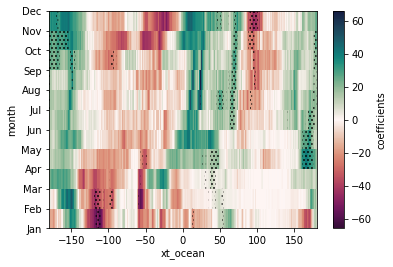

In [99]:
# coef = xr.concat(x, dim = 'month')
pval = xr.concat(y, dim = 'month')
pval = xr.where(pval <= 0.05, True, False)
(coef*1e-6).plot(cmap = cm.cm.curl_r)
pval.where(pval == 1, np.nan).plot.contourf(hatches = ['...'], colors = 'none', add_colorbar = False)

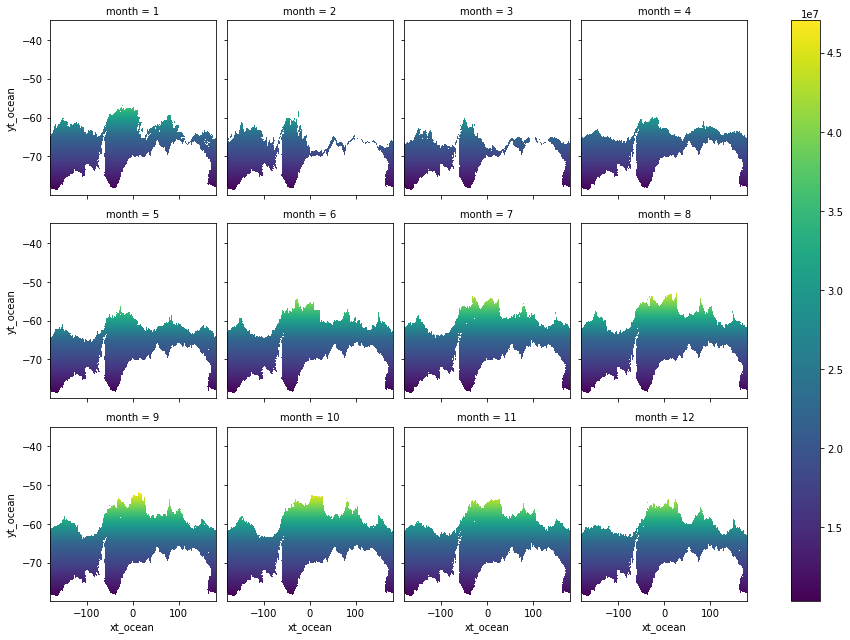

In [216]:
SIE.groupby('time.month').mean('time').plot(col = 'month', col_wrap = 4)

In [164]:
climdata = SIC.sel(time = slice('1978-12', '2008-11'))

seasons_SIC = {}

for season in seasonName.keys():
    y = []
    for i, m in enumerate(climdata.time.dt.month.values.tolist()):
        if m in seasonName[season]:
            y.append(climdata[i])
    seasons_SIC[season] = xr.concat(y, dim = 'time')

<xarray.DataArray (time: 90, xt_ocean: 3600)>
array([[14879445., 14879445., 14879445., ..., 14785931., 14841749.,
        14861374.],
       [15397852., 15397852., 15397852., ..., 15379647., 15379647.,
        15397852.],
       [16339954., 16339954., 16321923., ..., 16339954., 16339954.,
        16339954.],
       ...,
       [15616050., 15616050., 15616050., ..., 15616050., 15616050.,
        15616050.],
       [16213659., 16231711., 16231711., ..., 16213659., 16213659.,
        16213659.],
       [16357983., 16339954., 16321923., ..., 16394029., 16376007.,
        16376007.]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 1979-03-31T12:00:00 ... 2008-05-31T12:00:00
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9

In [94]:
# import statsmodels.api as sm
# decomposition = sm.tsa.seasonal_decompose(clipped_SIE['Atlantic'].drop('region').to_pandas(), model='additive')
# decomposition

# decomposition2 = sm.tsa.seasonal_decompose(x.sort_index(inplace = True), model='additive')
# decomposition2.plot()

# sm.tsa.seasonal_decompose(clipped_SIE['Atlantic'].groupby('time.season'), model = 'additive')

clipped_SIE['Atlantic'].drop('region').to_pandas()#['time']

# x = seasons_SIE['Atlantic_Autumn'].drop('region').to_pandas()
# # x.sort_index(inplace = True)
# x.sort_index(inplace = True)
# x

time
1964-12-31 12:00:00    5.177079e+12
1965-01-31 12:00:00    2.776212e+12
1965-02-28 12:00:00    7.035236e+11
1965-03-31 12:00:00    1.414288e+12
1965-04-30 12:00:00    3.345683e+12
                           ...     
2018-08-31 12:00:00    6.562940e+12
2018-09-30 12:00:00    6.433582e+12
2018-10-31 12:00:00    6.449174e+12
2018-11-30 12:00:00    5.673261e+12
2018-12-31 12:00:00    5.033518e+12
Length: 649, dtype: float64

## Defining functions

**Plotting timeseries for total sea ice coverage**  
The `SeaIceTimeSeries` function will plot the total sea ice area over the time period of interest. This function needs the following inputs:
- `array` which refers to the array containing data about sea ice area. It will be the output of `getACCESSdata`

**Returns:** Maximum sea ice extent value.

In [17]:
def SeaIceTimeSeries(array):
    #The sum of sea ice area will be calculated along all longitudes and latitudes
    TotalSI = array.sum('xt_ocean').sum('yt_ocean')
    
    #Calculating min, mean and max sea ice extent per year
    Min = TotalSI.groupby('time.year').min('time')
    Mean = TotalSI.groupby('time.year').mean('time')
    Max = TotalSI.groupby('time.year').max('time')
    
    #Extracting dates information and turning them into pandas datetimes
    Dates = xr.cftime_range(start = str(min(TotalSI['time'].values)), end = str(max(TotalSI['time'].values)), freq = 'A').to_datetimeindex()
    
    #Removing unused variables
    del TotalSI
    
    #Change global font and font size
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 14

    #Extract information about the plot (figure and axes)
    fig, ax = plt.subplots(figsize = (16.4, 8.2))
    #Using Dates information to plot dates. Transforming area units from m2 to km2.
    plt.plot(Dates, Min, color = '#ddaa33', linestyle = '-', marker = 'o', markersize = 5)
    del Min
    plt.plot(Dates, Mean, color = '#bb5566', linestyle = '-', marker = 'o', markersize = 5)
    del Mean
    plt.plot(Dates, Max, color = '#004488', linestyle = '-', marker = 'o', markersize = 5)

    #Adding a main title to the plot - Increasing font size
    plt.title('Sea ice extent in the Southern Ocean', fontsize = 16)

    #Changing y axes
    #Calculating the exponent of scientific notation in the y axis
    exp_yaxis = np.floor(np.log10(max(ax.get_yticks()))).astype(int)
    #The $ signs wrap the expression with special characters, the {} is used either as a placeholder or to 
    #include more than one character in an expression
    plt.ylabel(r'Sea ice area ($\times$10$e^{}$ $km^2$)'.format(exp_yaxis))
    #Changing the limits of the y axis. Max value is 10% more than maximum value in the data
    plt.ylim(0, np.floor(max(Max).values*1.1))
    #Removing the scientific notation from the top of the graph as it is already included in the y label
    ax.yaxis.get_offset_text().set_visible(False)
    
    #Changing x axis
    #Change axes labels
    plt.xlabel('Year')
    #Extract min and max dates
    datemin = min(Dates)
    datemax = max(Dates)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    #Change length of ticks - smaller for minor ticks
    ax.tick_params(axis = 'x', which = "major", length = 4)
    #Change the format of the dates shown (month abbreviation and year)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    #If more than 10 years are included in the graph rotate x labels
    if (max(Dates.year) - min(Dates.year)) > 10:
        plt.xticks(rotation = 90)
    
    #Set major gridlines to appear, but with high transparency
    ax.grid(True, color = "#b4b4b4", linestyle = '-', alpha = 0.2, linewidth = 0.5)
    
    #Automated path to save output to local folder
    if min(Dates.year) != max(Dates.year):
        plt.savefig(os.path.join('/g/data/v45/la6889/Figures/TimeSeries/SeaIce', ('TimeSeriesSeaIce' + str(min(Dates.year)) + '-' + str(max(Dates.year)) + '.png')), dpi = 300)
    else:
        plt.savefig(os.path.join('/g/data/v45/la6889/Figures/TimeSeries/SeaIce', ('TimeSeriesSeaIce' + str(min(Dates.year)) + '.png')), dpi = 300)
    
    #Return maximum value to set yearly y-axis
    return max(Max).values*1.1

**Mean monthly sea ice area**  
The `MonthlySeaIce` function will plot the mean monthly sea ice area over the time period of interest. This function needs the following inputs:
- `array` which refers to the array containing data about sea ice area. It will be the output of `getACCESSdata` function
- `max_yaxis` sets the maximum y axis value to be consistent throughout the time frame of analysis. If it is not provided, then the y axis changes freely.

In [18]:
def MonthlySeaIce(array, **kwargs):
    '''
    Additional inputs: max_yaxis
    '''
    #The sum of sea ice area will be calculated along all longitudes and latitudes
    MonMSI = array.groupby('time.month').mean('time').sum('xt_ocean').sum('yt_ocean')
    #Extracting months (in numbers) and changing to month abbreviation
    Months = [calendar.month_abbr[m] for m in MonMSI.month.values]

    #Extracting maximum and minimum year information
    MinY = min(array.indexes['time'].to_datetimeindex().year)
    MaxY = max(array.indexes['time'].to_datetimeindex().year)

    #Change global font and font size
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 14

    #Extract information about the plot (figure and axes)
    #Figure size set to 8.2" wide and 4.1" tall (fits across A4)
    fig, ax = plt.subplots(figsize = (16.4, 8.2))
    #Using Dates information to plot dates.
    ax.plot(Months, MonMSI.values, 
            #Line and and point plot. Changing color
            linestyle = '-', color = "#004488", marker = 'o', markersize = 5)

    #Adding a main title to the plot - Increasing font size
    if MinY != MaxY:
        plt.title('Mean monthly sea ice area in the Southern Ocean between {} and {}'.format(MinY, MaxY), 
              fontsize = 16)
    else:
        plt.title('Mean monthly sea ice area in the Southern Ocean in {}'.format(MinY), fontsize = 16)

    #Changing y axes
    if 'max_yaxis' in kwargs.keys():
        exp_yaxis = np.floor(np.log10(kwargs.get('max_yaxis'))).astype(int)
        plt.ylabel(r'Mean sea ice area per month ($\times$10$e^{}$ $km^2$)'.format(exp_yaxis))
        #Changing the limits of the y axis. Max value is 10% more than maximum value in the data
        plt.ylim(0, kwargs.get('max_yaxis'))
    else:    
        #Calculating the exponent of scientific notation in the y axis
        exp_yaxis = np.floor(np.log10(max(ax.get_yticks()))).astype(int)
        #The $ signs wrap the expression with special characters, the {} is used either as a placeholder or to 
        #include more than one character in an expression
        plt.ylabel(r'Mean sea ice area per month ($\times$10$e^{}$ $km^2$)'.format(exp_yaxis))
        #Changing the limits of the y axis. Max value is 10% more than maximum value in the data
        plt.ylim(0, np.floor(max(MonMSI).values*1e-6*1.1))
    #Removing the scientific notation from the top of the graph as it is already included in the y label
    ax.yaxis.get_offset_text().set_visible(False)

    #Changing x axis
    #Change axes labels
    plt.xlabel('Month')

    #Set major gridlines to appear, but with high transparency
    ax.grid(True, color = "#b4b4b4", linestyle = '-', alpha = 0.2)

    #Automatically saving figures to local folder
    if MinY != MaxY: 
        plt.savefig(os.path.join('/g/data/v45/la6889/Figures/LinePlots/MonthlySeaIce', ('MonthlyMeanSeaIce' + str(MinY) + '-' + str(MaxY) + '.png')), dpi = 300)
    else:
        plt.savefig(os.path.join('/g/data/v45/la6889/Figures/LinePlots/MonthlySeaIce', ('MonthlyMeanSeaIce' + str(MinY) + '.png')), dpi = 300)

**Map showing mean seasonal sea ice area**  
The `SeasonalSeaIceMap` function will create a map of the Southern Ocean showing mean sea ice coverage per season over the specified time period. This function takes the following inputs:  
- `array` which refers to the array containing the data to be processed and plotted. It will be the output of the `getACCESSdata` function.
- `contIce` which refers to the contour delimiting sea ice extent. By default is set to the 15% concentration contour. Input should be given as proportion (e.g., `contIce = 0.15` for contour line at 10% concentration).
- Optional inputs `**colPal`
    - `palette` defines the colour palette to be used. If Scientific Colour Maps by Crameri (2018) are to be used it expects a string as an input (e.g., `palette = 'oslo'`), otherwise it expects a matplotlib colormap (e.g., `palette = cm.cm.ice`).
    - `colbar` defines whether colourbars are needed for each plot (e.g., `colbar = 'each'`) or for the entire figure. 
If no palette is given, `cmocean ice` palette is used as default. If colbar is not specified then only one colourbar will be included in the figure.  
  
If the **Scientific Colour Maps by Crameri (2018)** are used, they should be properly cited using either of the citations below. See documentation for additional information:  
Crameri, F. (2018), Scientific colour-maps, Zenodo, doi:10.5281/zenodo.1243862
Crameri, F. (2018), Geodynamic diagnostics, scientific visualisation and StagLab 3.0, Geosci. Model Dev., 11, 2541-2562,
doi:10.5194/gmd-11-2541-2018.  
Guidelines on how to choose a good colour palette can be found here: [http://www.fabiocrameri.ch/colourmap-type.php].  

In [19]:
def SeasonalSeaIceMap(array, contIce = 0.15, **colPal):
    '''
    Additional arguments include: palette, colbar
    Sea ice extent defined as the 15% concentration contour by default
    '''
    #Check if the 'palette' argument has been defined
    if 'palette' in colPal.keys():
        #If the 'palette' argument is a string
        if isinstance(colPal.get('palette'), str):
            #Defining colour palette from Scientific Colour Maps
            #Load relevant libraries to set Scientific Colour Map library
            from matplotlib.colors import LinearSegmentedColormap
            #Set path where the scientific library is found
            cm_data = np.loadtxt(os.path.join('../../ScientificColourMaps6', colPal['palette'], (colPal['palette'] + '.txt')))
            #Create a colour map based on 'palette' argument
            pal_map = LinearSegmentedColormap.from_list(colPal['palette'], cm_data)
        #If the 'palette' argument is NOT a string
        elif not isinstance(colPal.get('palette'), str):
            #Load the colour palette defined in the 'palette' argument
            pal_map = colPal['palette']
    #If 'palette' argument has not been defined, then use cmocean ice palette as default
    else:
        pal_map = cm.cm.ice
        
    #Calling libraries to edit long and lat labels
    import matplotlib.ticker as mticker
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    
    #The sum of sea ice area will be calculated along all longitudes and latitudes
    SeasonSI = array.groupby('time.season').mean('time')

    #Extracting maximum and minimum year information
    MinY = min(array.indexes['time'].to_datetimeindex().year)
    MaxY = max(array.indexes['time'].to_datetimeindex().year)
    
    #Defining season names
    seasonName = {'DJF': 'Austral summer', 'MAM': 'Austral autumn', 'JJA': 'Austral winter', 'SON': 'Austral spring'}

    #Change global font and font size
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 14

    #Define the contour lines to be shown in the graph. From 0 to 1 and increasing by 0.005.
    levels = np.arange(0, 1.01, .05)
#     levels = np.arange(0, 1.01, .1) #activate when testing for faster figure rendering

    #Stretch the colourbar to emphasise the differences in high and low sea ice concentration areas
#     cmap_gamma = 2. # exponent for power-law stretch of colormap
#     cbar_ticks = [f**cmap_gamma for f in [0, .3, .4, .5, .6, .7, .8, .85, .9, .95, 1]]
    cbar_ticks = [round(i, 1) for i in np.arange(0, 1.01, 0.1)]

    #Define projection to polar
    projection = ccrs.SouthPolarStereo()

    #Create variable containing the Antarctic continent - 50m is medium scale
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', linewidth = 0.5)

    #Create composite figures
    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 14), 
                             subplot_kw = dict(projection = projection))
    #Create counter using a list: i and j define the plot, while season refers to season
    for i, j, season in [(0, 0, 'DJF'), (0, 1, 'MAM'), (1, 0, 'JJA'), (1, 1, 'SON')]:
        #Extract information for each season and start plotting
        #pcolormesh creates a pseudo color map with a non-rectangular grid
        #cmap_gamma to be applied as exponent to data being plotted
        p1 = (SeasonSI.sel(season = season)).\
        plot.contourf(x = 'xt_ocean', y = 'yt_ocean', ax = axes[i, j], 
                      #Setting scientific palette as color palette and defining min-max values for colourbar
                      cmap = pal_map, vmin = 0, vmax = 1,
                      #Setting contour levels
                      levels = levels,
                      #Remove colourbar to allow for further manipulation
                      transform = ccrs.PlateCarree(), add_colorbar = False)
        SeasonSI.sel(season = season).plot.contour(x = 'xt_ocean', y = 'yt_ocean', ax = axes[i, j],
                                                   levels = [contIce], colors = 'white', linewidths = 1,
                                                   transform = ccrs.PlateCarree())
        #Set title for each subplot using season dictionaries. Move the title along the y axis so it is not too far from the plot
        axes[i,j].set_title(seasonName[season] + ' mean (months: ' + season + ')', y = 1.01)
        #Remove x and y axes labels
        axes[i,j].set_ylabel("")
        axes[i,j].set_xlabel("")

        #Change the colourbars for each figure
        #Set values outside the upper limit to be gray
        p1.cmap.set_over(color = '#e7e4d9', alpha = None)
        
        #If the 'colbar' argument exist and it was set to 'each', then this section will be activated
        if 'colbar' in colPal.keys() and colPal.get('colbar').lower() == "each":
            #Set colourbar to be horizontal, 70% its original size and a distance equal to 9% of total figure area from the plot
            cb = fig.colorbar(p1, ax = axes[i,j], orientation = 'horizontal', shrink = 0.8, pad = 0.09)
            #Set title for colourbar
            cb.ax.set_xlabel('Sea ice concentration')
            #Setting colourbar ticks and labels
            cb.set_ticks(cbar_ticks)
#             cb.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
            cb.set_ticklabels(cbar_ticks)

    #Changing other parameters
    for ax in axes.flat:
        #Coastlines to appear
        ax.coastlines(resolution = '50m')
        #Add feature loaded at the beginning of this section
        ax.add_feature(land_50m)
        #Set the extent of maps
        ax.set_extent([-280, 80, -80, -50], crs = ccrs.PlateCarree())
        #Adding gridlines gridlines - Removing any labels inside the map on the y axis
        gl = ax.gridlines(draw_labels = True, y_inline = False, color = "#b4b4b4", alpha = 0.6)
        #Locate longitude ticks - Set to every 30 deg
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
        #Give longitude labels the correct format for longitudes
        gl.xformatter = LONGITUDE_FORMATTER
        #Set rotation of longitude labels to zero
        gl.xlabel_style = {'rotation': 0}
        #Set latitude labels to be transparent
        gl.ylabel_style = {'alpha': 0}
        #Add space between axis ticks and labels for x and y axes
        gl.xpadding = 8
        gl.ypadding = 8
        gl.xlabels_left = False
        gl.ylabels_right = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        if ax.colNum == 0 and ax.rowNum == 1:
            gl.ylabels_left = True
            gl.xlabels_bottom = True
        elif ax.colNum == 0 and ax.rowNum != 1:
            gl.ylabels_left = True
            gl.xlabels_bottom = False
        elif ax.colNum != 0 and ax.rowNum == 1:
            gl.ylabels_left = False
            gl.xlabels_bottom = True
        elif ax.colNum != 0 and ax.rowNum != 1:
            gl.ylabels_left = False
            gl.xlabels_bottom = False

    #Set title for composite figure. Move the title along the y axis so it is not too far from 
    if MinY != MaxY:
        fig.suptitle('Mean sea ice concentration per season between ' + str(MinY) + ' and '+ str(MaxY), y = 0.95, x = 0.45)
    else:
        fig.suptitle('Mean sea ice concentration per season in ' + str(MinY), y = 0.95, x = 0.45)

    #Decrease white space between each row of plots
    plt.subplots_adjust(hspace = 0.09, wspace = 0.05)

    #If the 'colbar' argument does not exist, or if it exist and it has not been set to 'each', then this section will be activated and one colourbar will be included in the figure
    if 'colbar' not in colPal.keys() or colPal.get('colbar').lower() != "each":
        #Change one colourbar for all figures
        #Set vertical colourbar for all subplots, 50% of original size and a distance equal to 2% of total figure area from the plot
        cb = fig.colorbar(p1, ax = axes[:,:], orientation = 'vertical', shrink = 0.5, pad = 0.02)
        #Set title for colourbar
        cb.ax.set_ylabel('Sea ice concentration')
        #Setting colourbar ticks and labels
        cb.set_ticks(cbar_ticks)
#         cb.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
        cb.set_ticklabels(cbar_ticks)
        
#     #Automatically saving figures to local folder
    if MinY != MaxY:
        plt.savefig(os.path.join('/g/data/v45/la6889/Figures/Maps/SeasonalSeaIce', ('MapSeasonalMeanSeaIce' + str(MinY) + '-' + str(MaxY) + '.png')), dpi = 300)
    else:
        plt.savefig(os.path.join('/g/data/v45/la6889/Figures/Maps/SeasonalSeaIce', ('MapSeasonalMeanSeaIce' + str(MinY) + '.png')), dpi = 300)

**Map showing mean monthly sea ice area**  
The `MonthlySeaIceMap` function will create a map of the Southern Ocean showing mean sea ice coverage per season over the specified time period. This function takes the following inputs:  
- `array` which refers to the array containing the data to be processed and plotted. It will be the output of the `getACCESSdata` function.
- `contIce` which refers to the contour delimiting sea ice extent. By default is set to the 15% concentration contour. Input should be given as proportion (e.g., `contIce = 0.15` for contour line at 10% concentration).
- Optional inputs `**kwargs`
    - `palette` defines the colour palette to be used. If Scientific Colour Maps by Crameri (2018) are to be used it expects a string as an input (e.g., `palette = 'oslo'`), otherwise it expects a matplotlib colormap (e.g., `palette = cm.cm.ice`).
    - `colbar` defines whether colourbars are needed for each plot (e.g., `colbar = 'each'`) or for the entire figure. 
If no palette is given, `cmocean ice` palette is used as default. If colbar is not specified then only one colourbar will be included in the figure.  
  
If the **Scientific Colour Maps by Crameri (2018)** are used, they should be properly cited using either of the citations below. See documentation for additional information:  
Crameri, F. (2018), Scientific colour-maps, Zenodo, doi:10.5281/zenodo.1243862
Crameri, F. (2018), Geodynamic diagnostics, scientific visualisation and StagLab 3.0, Geosci. Model Dev., 11, 2541-2562,
doi:10.5194/gmd-11-2541-2018.  
Guidelines on how to choose a good colour palette can be found here: [http://www.fabiocrameri.ch/colourmap-type.php].

In [20]:
def MonthlySeaIceMap(array, contIce = 0.15, **colPal):
    '''
    Additional arguments include: palette, colbar
    Sea ice extent defined as the 15% concentration contour by default
    '''
    #Check if the 'palette' argument has been defined
    if 'palette' in colPal.keys():
        #If the 'palette' argument is a string
        if isinstance(colPal.get('palette'), str):
            #Defining colour palette from Scientific Colour Maps
            #Load relevant libraries to set Scientific Colour Map library
            from matplotlib.colors import LinearSegmentedColormap
            #Set path where the scientific library is found
            cm_data = np.loadtxt(os.path.join('../../ScientificColourMaps6', colPal['palette'], (colPal['palette'] + '.txt')))
            #Create a colour map based on 'palette' argument
            pal_map = LinearSegmentedColormap.from_list(colPal['palette'], cm_data)
        #If the 'palette' argument is NOT a string
        elif not isinstance(colPal.get('palette'), str):
            #Load the colour palette defined in the 'palette' argument
            pal_map = colPal['palette']
    #If 'palette' argument has not been defined, then use cmocean ice palette as default
    else:
        pal_map = cm.cm.ice
        
    #Calling libraries to edit long and lat labels
    import matplotlib.ticker as mticker
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    
    #The sum of sea ice area will be calculated along all longitudes and latitudes
    SeasonSI = array.groupby('time.month').mean('time')

    #Extracting maximum and minimum year information
    MinY = min(array.indexes['time'].to_datetimeindex().year)
    MaxY = max(array.indexes['time'].to_datetimeindex().year)
    
    #Change global font and font size
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 14

    #Define the contour lines to be shown in the graph. From 0 to 1 and increasing by 0.005.
    levels = np.arange(0, 1.01, .05)
#     levels = np.arange(0, 1.01, .5) #activate when testing for faster figure rendering

    #Stretch the colourbar to emphasise the differences in high and low sea ice concentration areas
#     cmap_gamma = 2. # exponent for power-law stretch of colormap
#     cbar_ticks = [f**cmap_gamma for f in [0, .3, .4, .5, .6, .7, .8, .85, .9, .95, 1]]
    cbar_ticks = [round(i, 1) for i in np.arange(0, 1.01, 0.1)]

    #Define projection to polar
    projection = ccrs.SouthPolarStereo()

    #Create variable containing the Antarctic continent - 50m is medium scale
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', linewidth = 0.5)

    #Create composite figures
    fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (16, 14), subplot_kw = dict(projection = projection))
    #Create counter using a list: i and j define the plot, while season refers to season
    for i, j, m in [(0, 0, 1), (0, 1, 2), (0, 2, 3), (1, 0, 4), (1, 1, 5), (1, 2, 6), (2, 0, 7), (2, 1, 8), (2, 2, 9), (3, 0, 10), (3, 1, 11), (3, 2, 12)]:
        #Extract information for each season and start plotting
        #pcolormesh creates a pseudo color map with a non-rectangular grid
        #cmap_gamma to be applied as exponent to data being plotted
#         p1 = (SeasonSI.sel(month = m)**cmap_gamma).\
        p1 = (SeasonSI.sel(month = m)).\
        plot.contourf(x = 'xt_ocean', y = 'yt_ocean', ax = axes[i, j], 
                      #Setting scientific palette as color palette and defining min-max values for colourbar
                      cmap = pal_map, vmin = 0, vmax = 1, 
                      #Setting contour levels
                      levels = levels,
                      #Remove colourbar to allow for further manipulation
                      transform = ccrs.PlateCarree(), add_colorbar = False)
        SeasonSI.sel(month = m).plot.contour(x = 'xt_ocean', y = 'yt_ocean', ax = axes[i,j],
                                                   levels = [contIce], colors = 'white', linewidths = 1,
                                                   transform = ccrs.PlateCarree())
        #Set title for each subplot using season dictionaries. Move the title along the y axis so it is not too far from the plot
        axes[i,j].set_title(calendar.month_name[m], y = 1.01)
        #Remove x and y axes labels
        axes[i,j].set_ylabel("")
        axes[i,j].set_xlabel("")

        #Change the colourbars for each figure
        #Set values outside the upper limit to be gray
        p1.cmap.set_over(color = '#e7e4d9', alpha = None)
        
        #If the 'colbar' argument exist and it was set to 'each', then this section will be activated
        if 'colbar' in colPal.keys() and colPal.get('colbar').lower() == "each":
            #Set colourbar to be horizontal, 70% its original size and a distance equal to 9% of total figure area from the plot
            cb = fig.colorbar(p1, ax = axes[i,j], orientation = 'horizontal', shrink = 0.8, pad = 0.09)
            #Set title for colourbar
            cb.ax.set_xlabel('Sea ice concentration')
            #Setting colourbar ticks and labels
            cb.set_ticks(cbar_ticks)
#             cb.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
            cb.set_ticklabels(cbar_ticks)

    #Changing other parameters
    for ax in axes.flat:
        #Coastlines to appear
        ax.coastlines(resolution = '50m')
        #Add feature loaded at the beginning of this section
        ax.add_feature(land_50m)
        #Set the extent of maps
        ax.set_extent([-280, 80, -80, -50], crs = ccrs.PlateCarree())
        ax.xaxis.set_tick_params(pad = 10)
        #Adding gridlines gridlines - Removing any labels inside the map on the y axis
        gl = ax.gridlines(draw_labels = True, y_inline = False, color = "#b4b4b4", alpha = 0.6)
        #Locate longitude ticks - Set to every 30 deg
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
        #Give longitude labels the correct format for longitudes
        gl.xformatter = LONGITUDE_FORMATTER
        #Set rotation of longitude labels to zero
        gl.xlabel_style = {'rotation': 0}
        #Set latitude labels to be transparent
        gl.ylabel_style = {'alpha': 0}
        #Add space between axis ticks and labels for x and y axes
        gl.xpadding = 8
        gl.ypadding = 8
        gl.xlabels_left = False
        gl.ylabels_right = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        if ax.colNum == 0 and ax.rowNum == 3:
            gl.ylabels_left = True
            gl.xlabels_bottom = True
        elif ax.colNum == 0 and ax.rowNum != 3:
            gl.ylabels_left = True
            gl.xlabels_bottom = False
        elif ax.colNum != 0 and ax.rowNum == 3:
            gl.ylabels_left = False
            gl.xlabels_bottom = True
        elif ax.colNum != 0 and ax.rowNum != 3:
            gl.ylabels_left = False
            gl.xlabels_bottom = False

    #Set title for composite figure. Move the title along the y axis so it is not too far from 
    if MinY != MaxY:
        fig.suptitle('Mean sea ice concentration per month between ' + str(MinY) + ' and '+ str(MaxY), y = 0.94)
    else:
        fig.suptitle('Mean sea ice concentration per month in ' + str(MinY), y = 0.94)

    #Decrease white space between each row of plots
    plt.subplots_adjust(hspace = 0.2, wspace = 0)

    #If the 'colbar' argument does not exist, or if it exist and it has not been set to 'each', then this section will be activated and one colourbar will be included in the figure
    if 'colbar' not in colPal.keys() or colPal.get('colbar').lower() != "each":
        #Change one colourbar for all figures
        #Set vertical colourbar for all subplots, 50% of original size and a distance equal to 2% of total figure area from the plot
        cb = fig.colorbar(p1, ax = axes[:,:], orientation = 'vertical', shrink = 0.5, pad = 0.02)
        #Set title for colourbar
        cb.ax.set_ylabel('Sea ice concentration')
        #Setting colourbar ticks and labels
        cb.set_ticks(cbar_ticks)
#         cb.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
        cb.set_ticklabels(cbar_ticks)
        
    #Automatically saving figures to local folder
    if MinY != MaxY:
        plt.savefig(os.path.join('/g/data/v45/la6889/Figures/Maps/MonthlySeaIce', ('MapMonthlyMeanSeaIce' + str(MinY) + '-' + str(MaxY) + '.png')), dpi = 300)
    else:
        plt.savefig(os.path.join('/g/data/v45/la6889/Figures/Maps/MonthlySeaIce', ('MapMonthlyMeanSeaIce' + str(MinY) + '.png')), dpi = 300)

## Applying functions
A variety of plots showing sea ice area changes in the Southern Ocean will be created below and saved in a folder using years of data shown in the graph as a unique identifier.

The `aice_m` variable gives the mean monthly concentration of ice in a cell. In other words, this represents the monthly mean proportion of ice found in a given grid cell. To calculate the area covered by ice, the area of each cell is needed.  
The area is saved as `area_t` and it is given by the ocean model, below we will load it to the notebook and multiply it by `aice_m` to get the total ice area.

In [42]:
#Loading ice area data (in m2) - Only one file needed as they will be the same regardless of the time
IceArea = xr.open_dataarray('/g/data/v45/la6889/Calculations/Area_per_pixel_01deg/area_per_pixel_01deg_all_areas.nc')

# #Accessing ACCESS 0.1deg outputs for the entire time range of interest
# SO = getACCESSdata(varInt, stime[0], etime[-1], minlon = -80, maxlon = -35)

#Transforming area from m2 to km2
# SOIce = SO*IceArea*1e-6

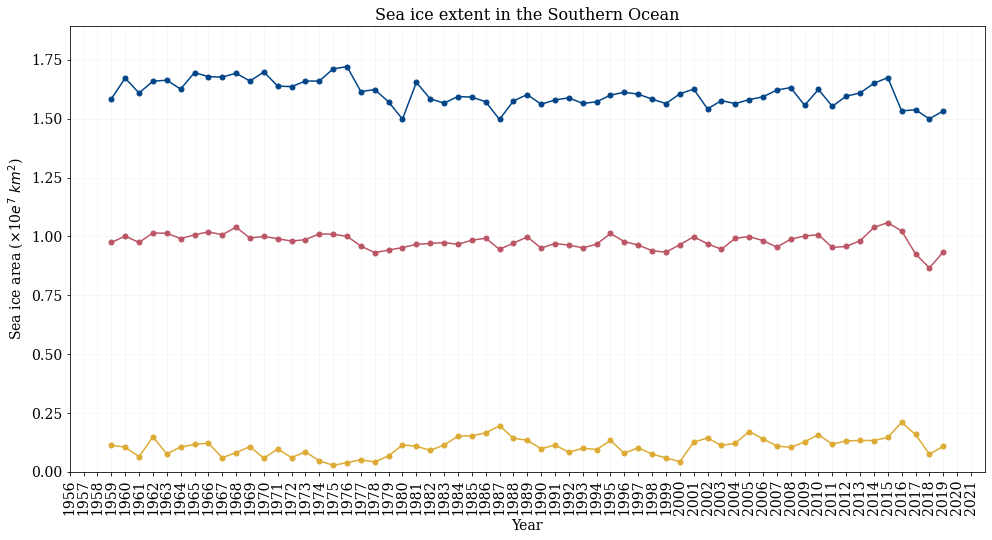

In [22]:
#Making time series graphs (all dates)
maxIce = SeaIceTimeSeries(SOIce)

Use the chunk below if yearly calculations are necessary.  
In MonthlySeaIce, `max_yaxis = 18933857.8` is used as this value corresponds to the maximum value (+ 10%) calculated for the entire period of study (1958 - 2018).

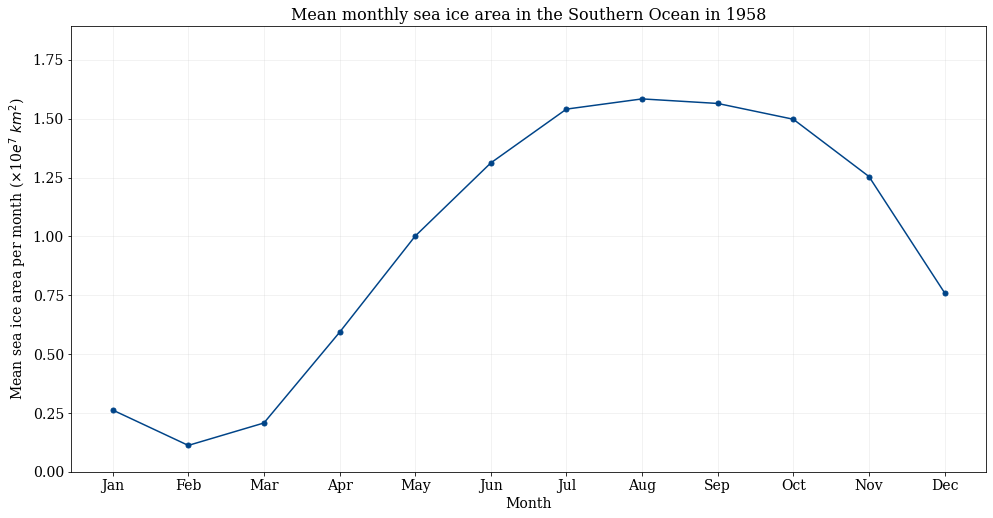

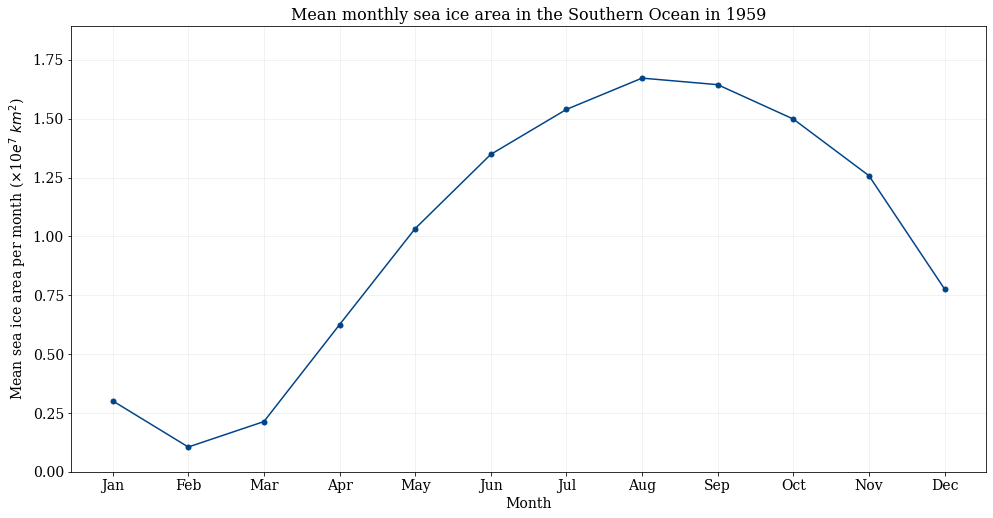

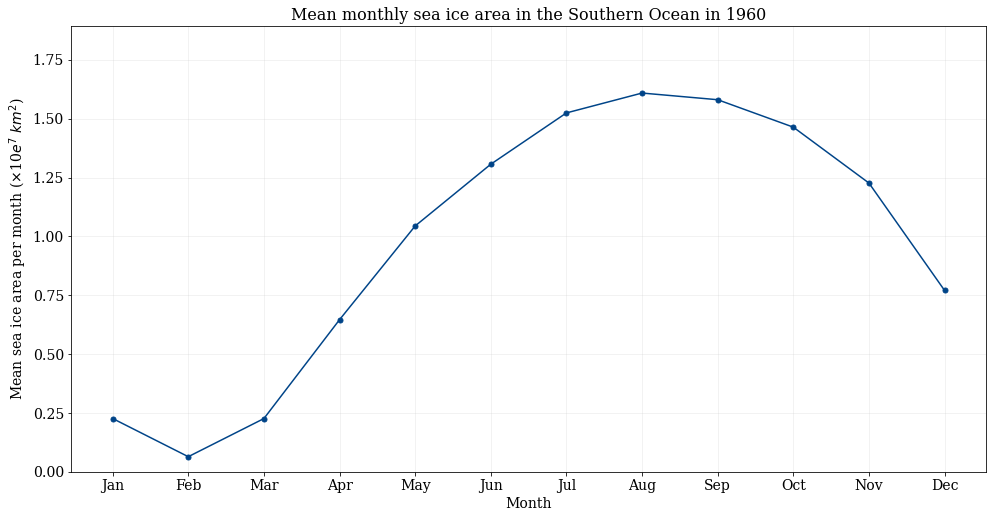

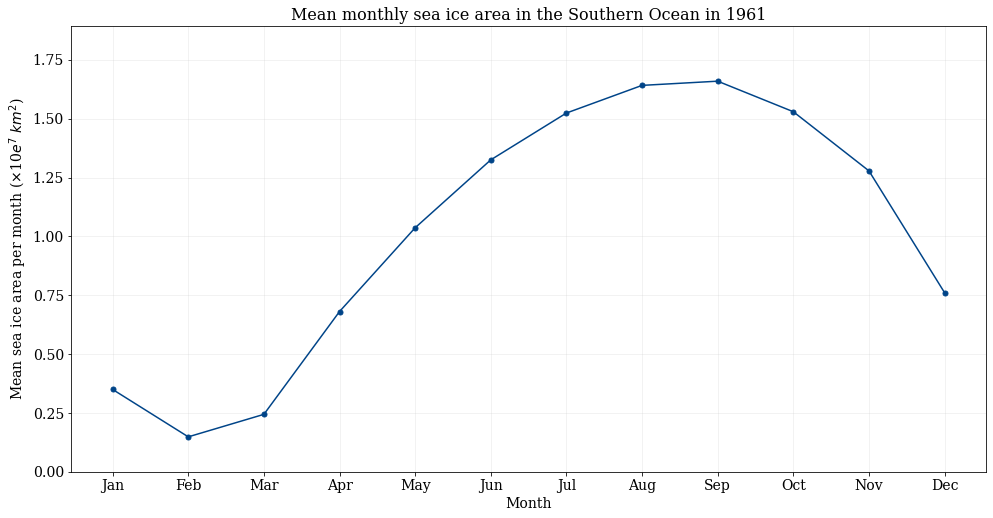

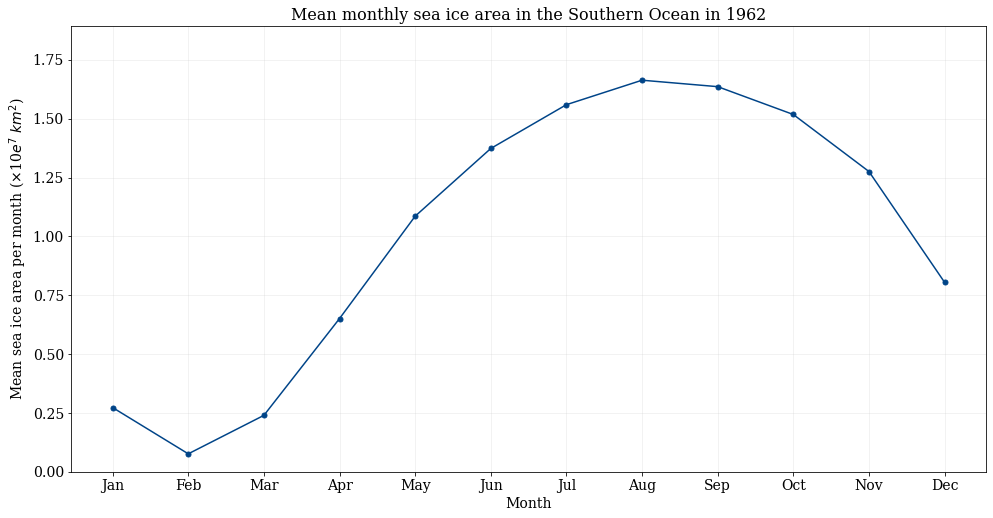

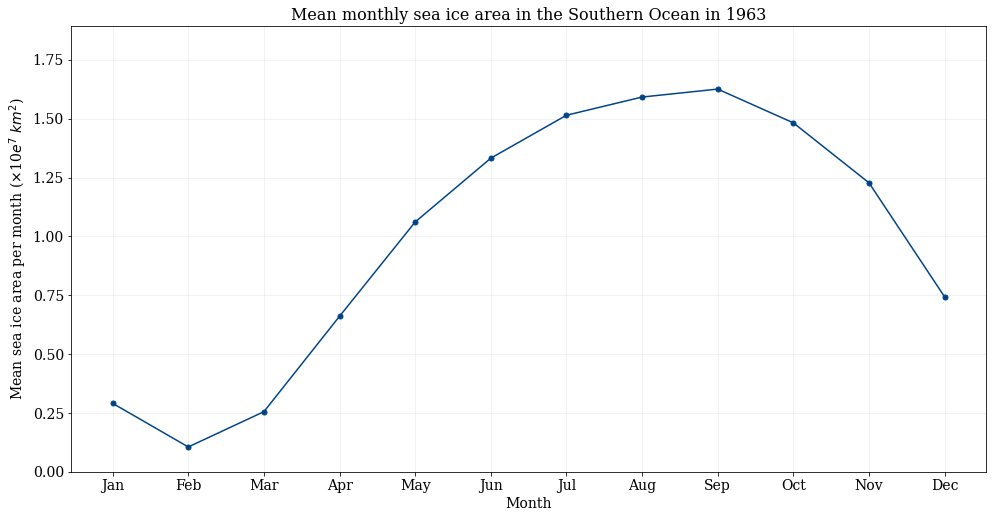

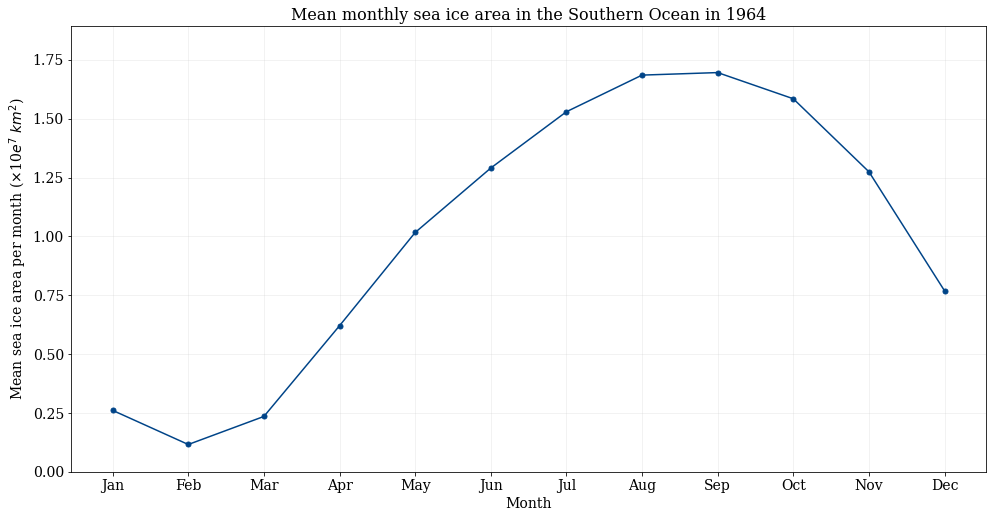

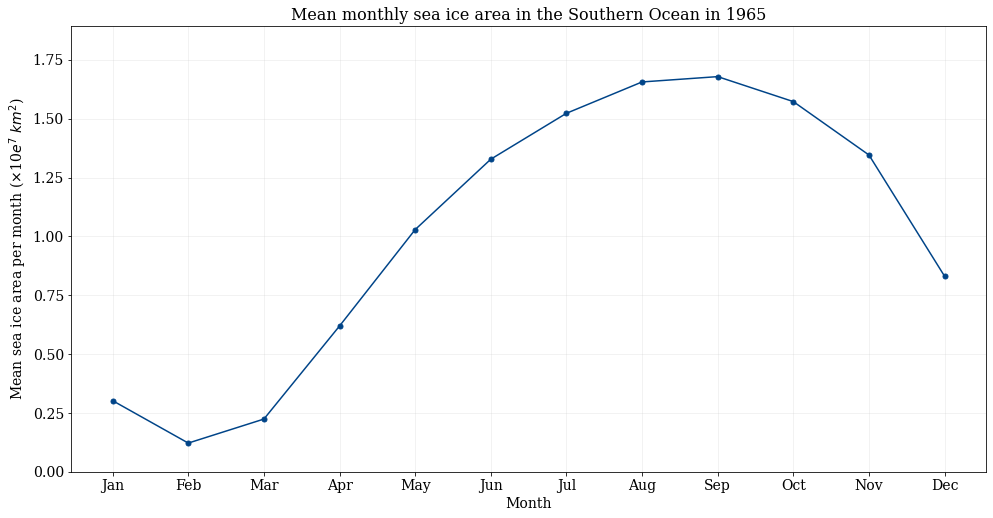

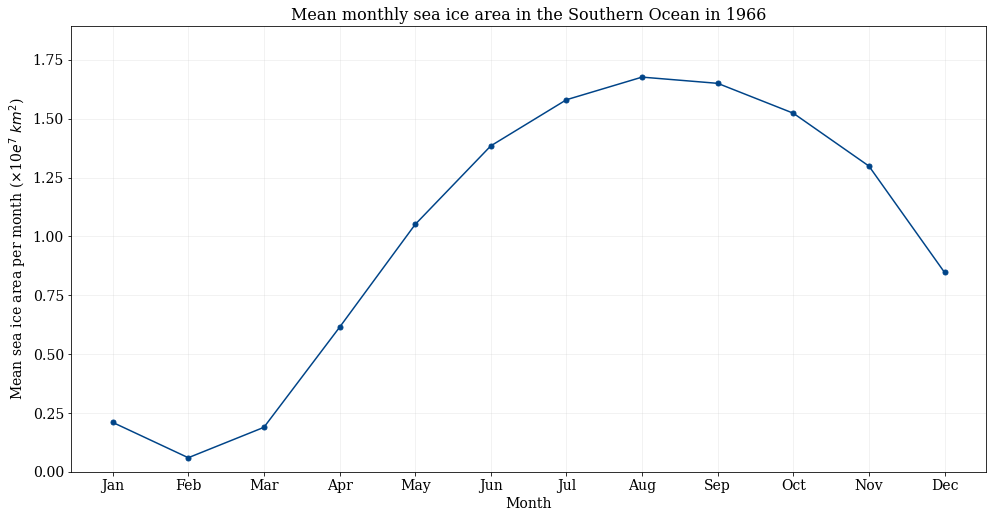

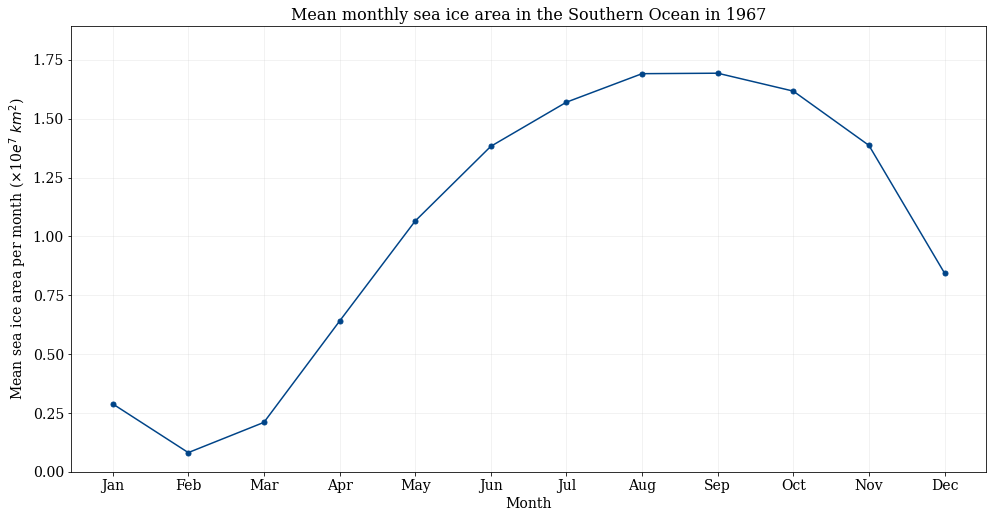

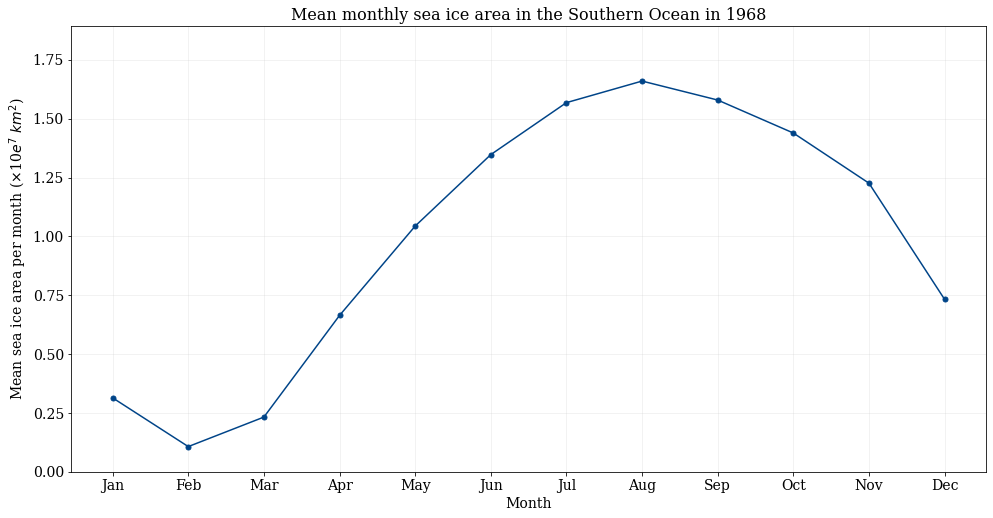

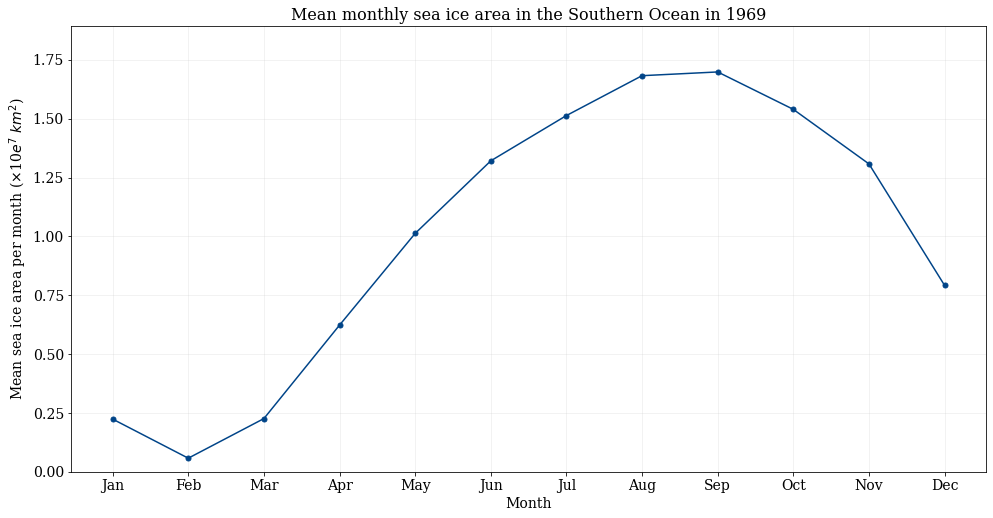

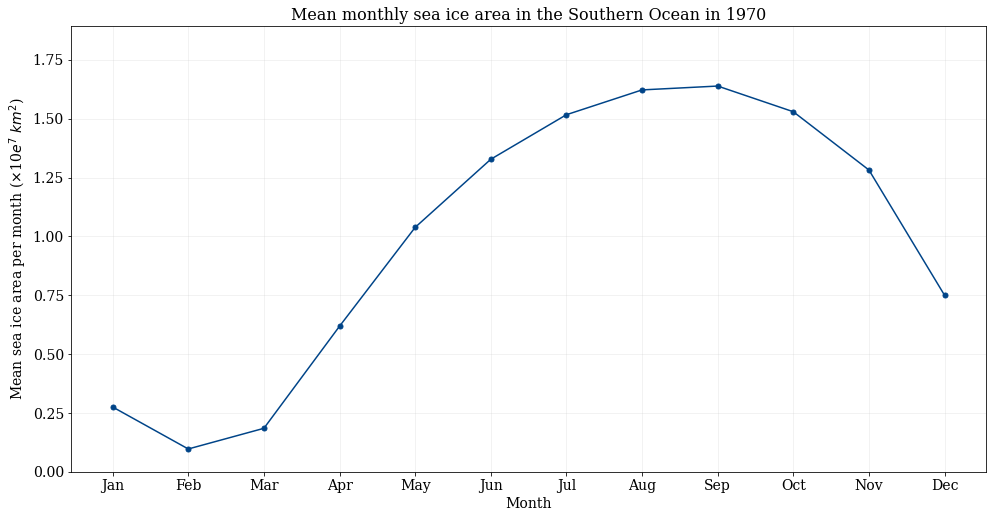

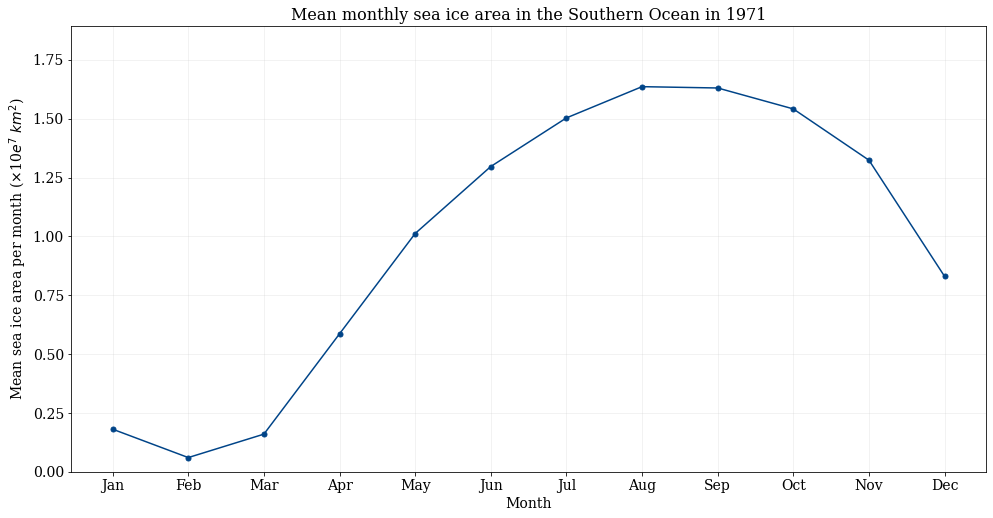

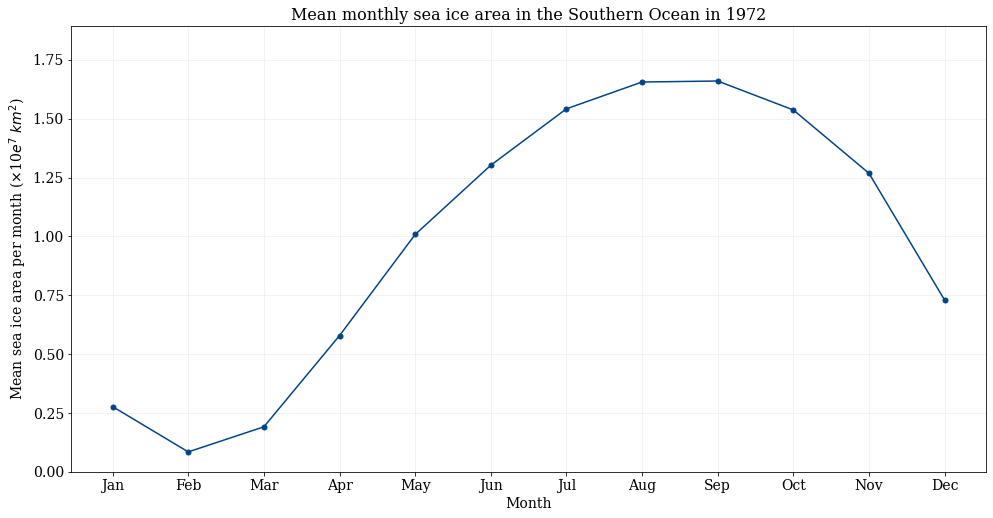

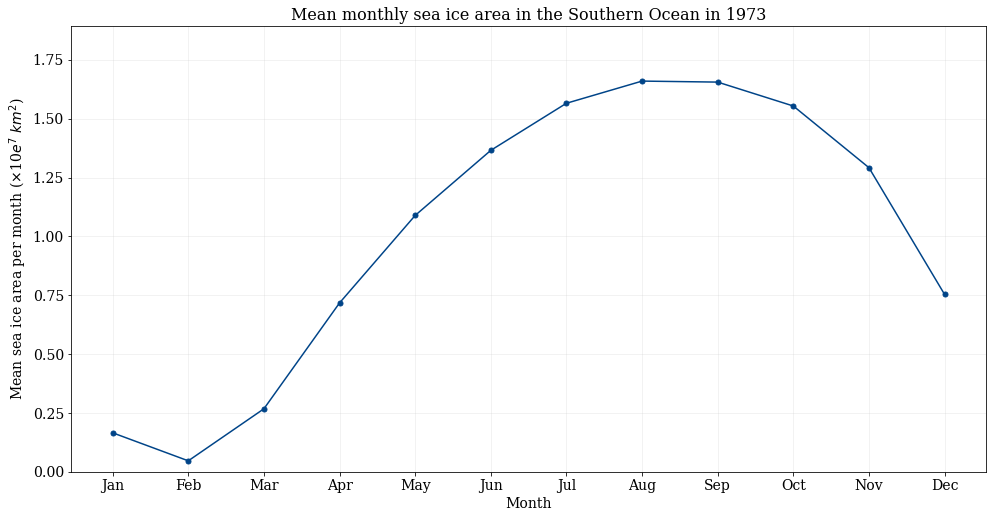

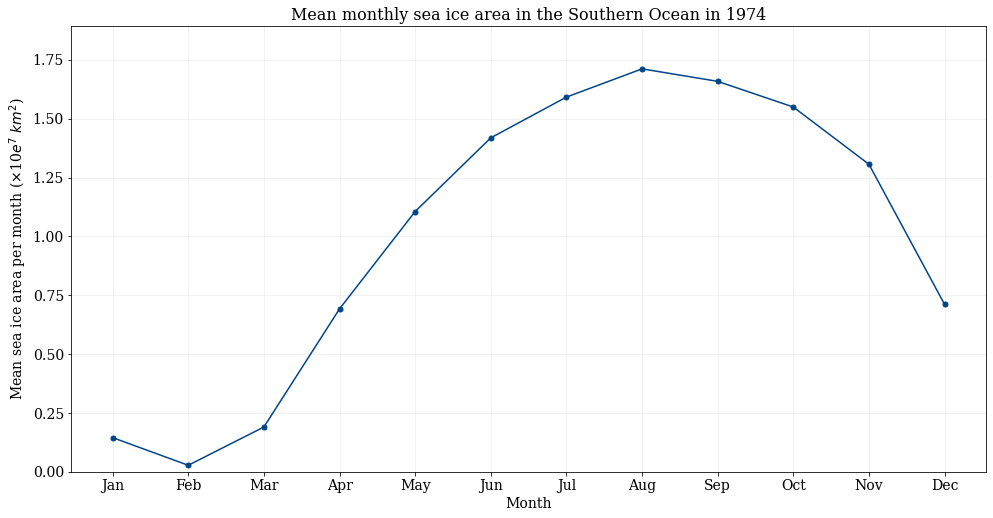

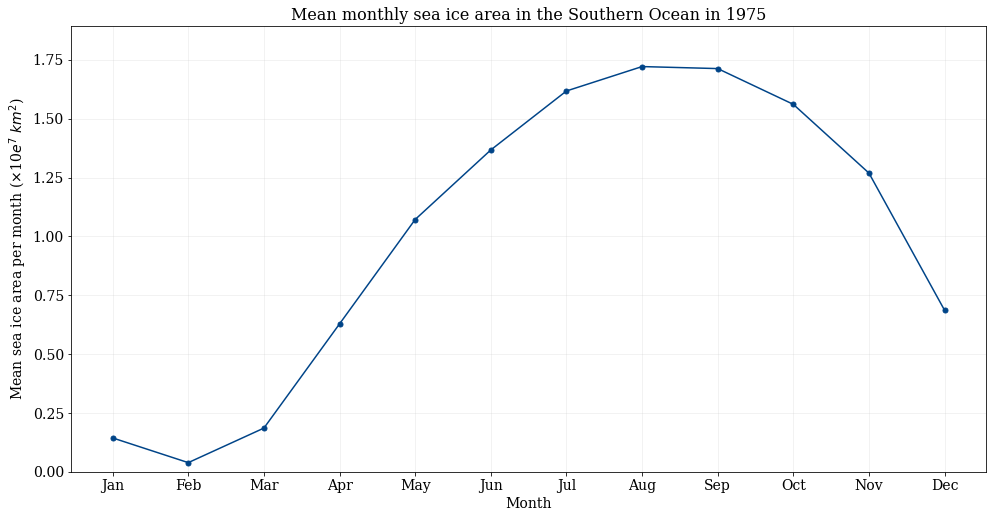

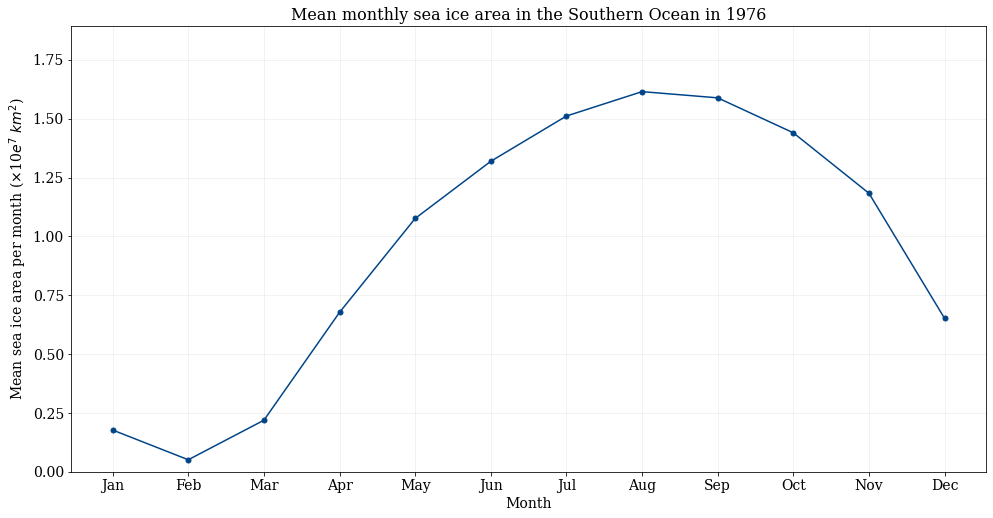

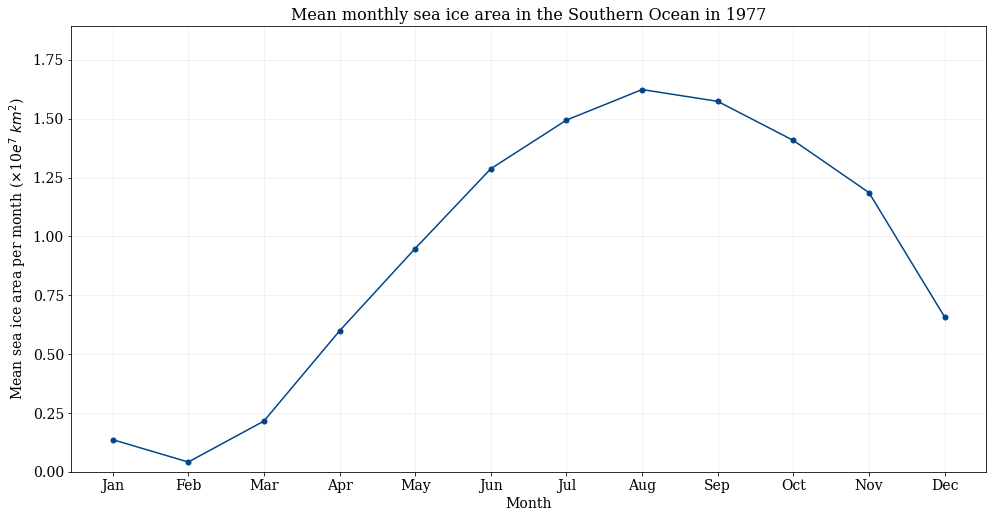

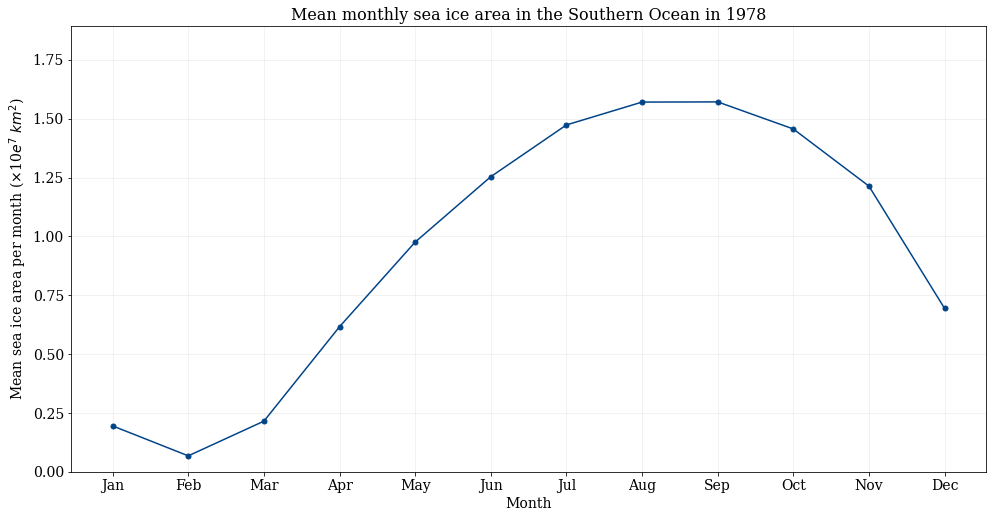

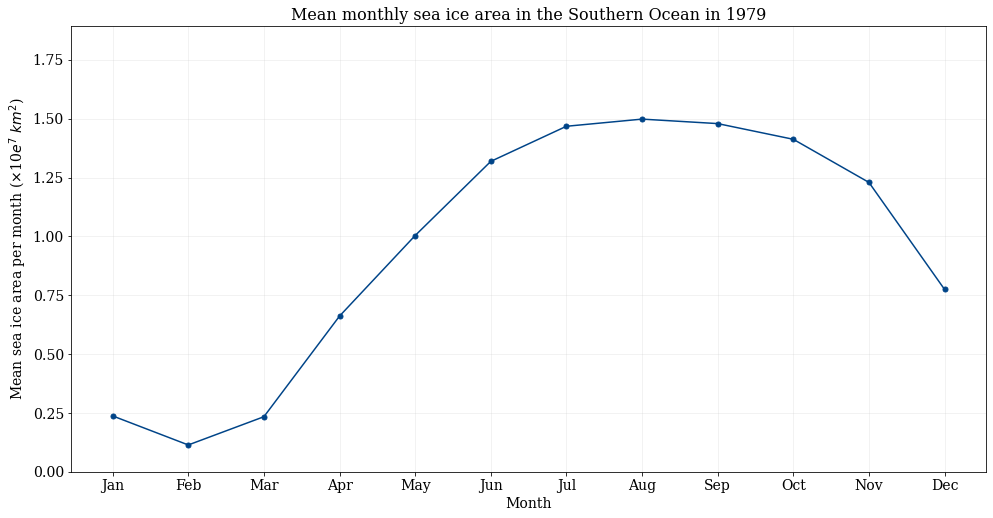

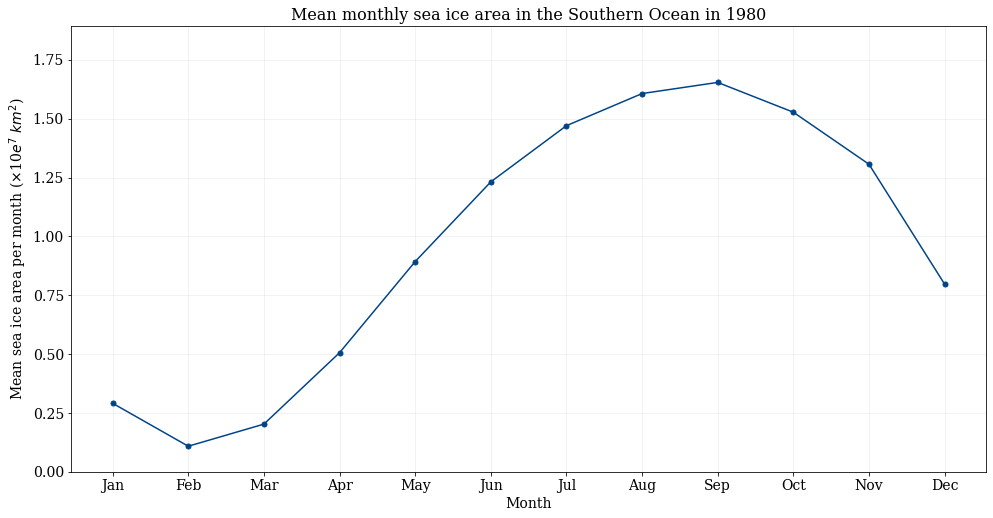

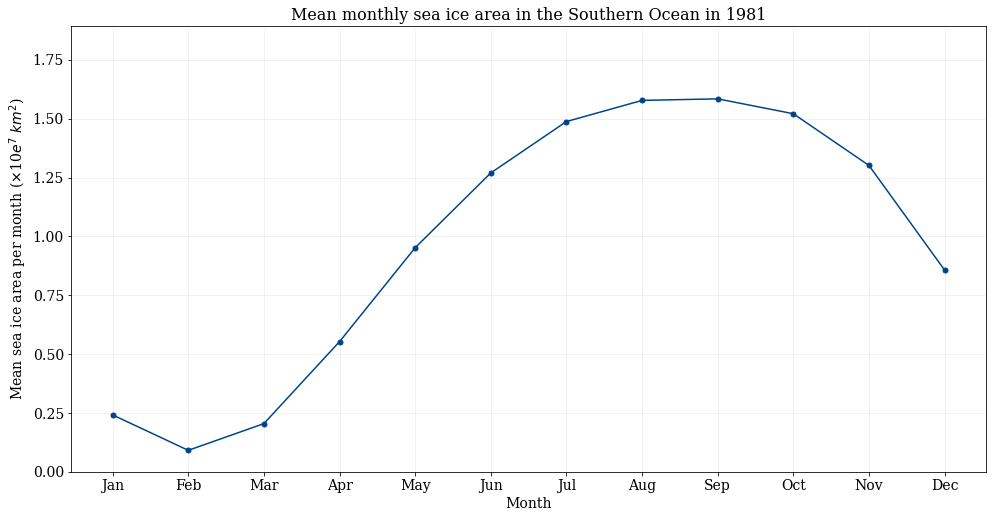

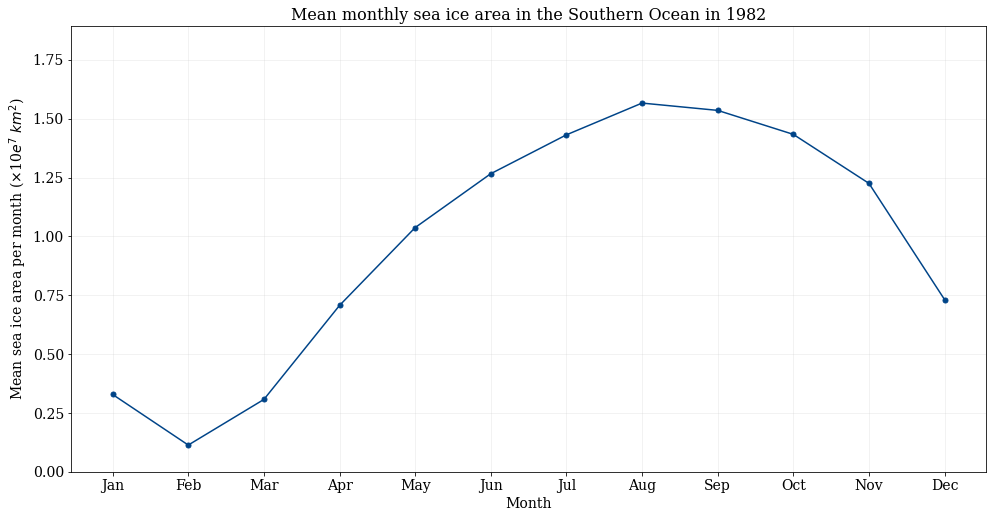

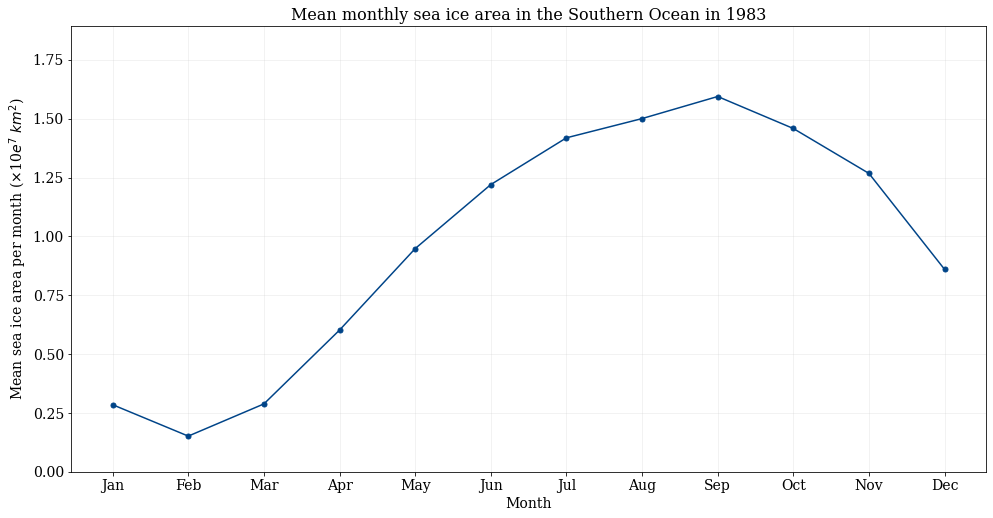

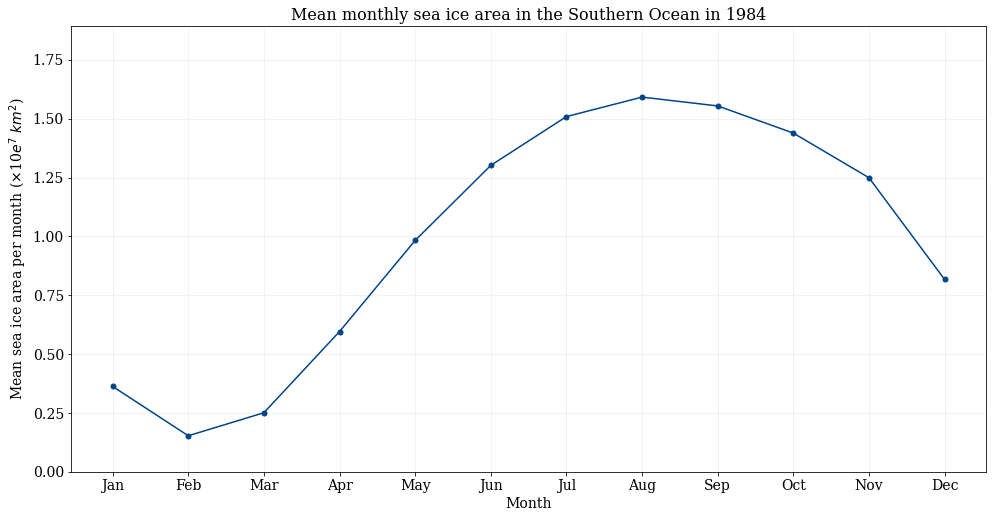

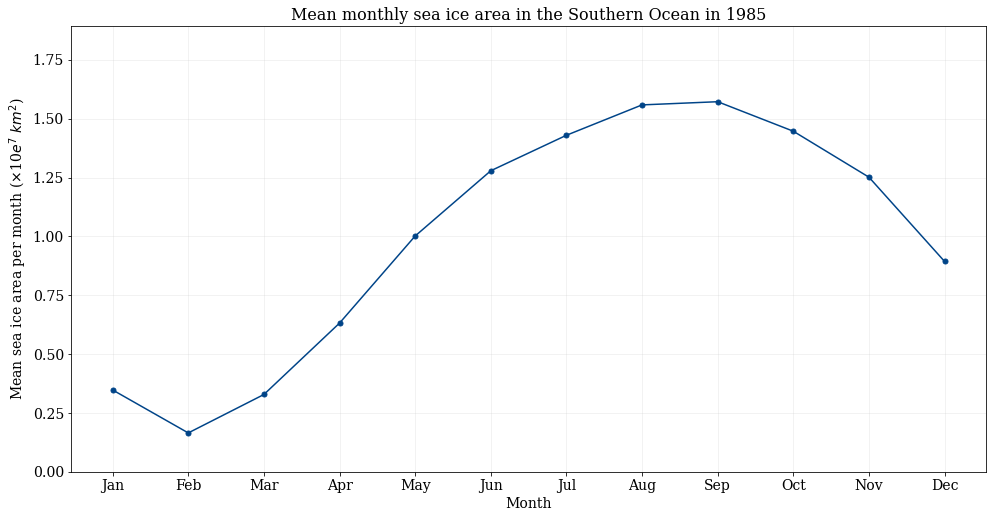

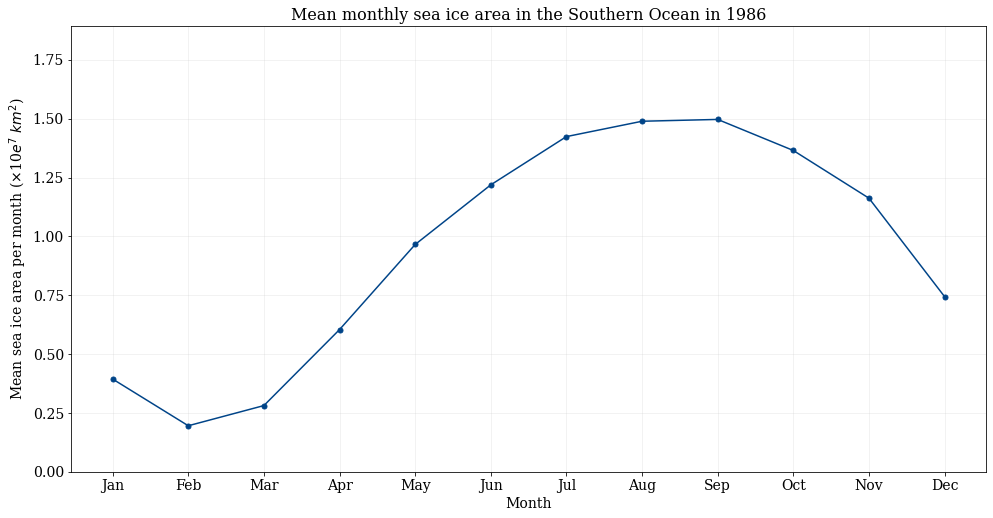

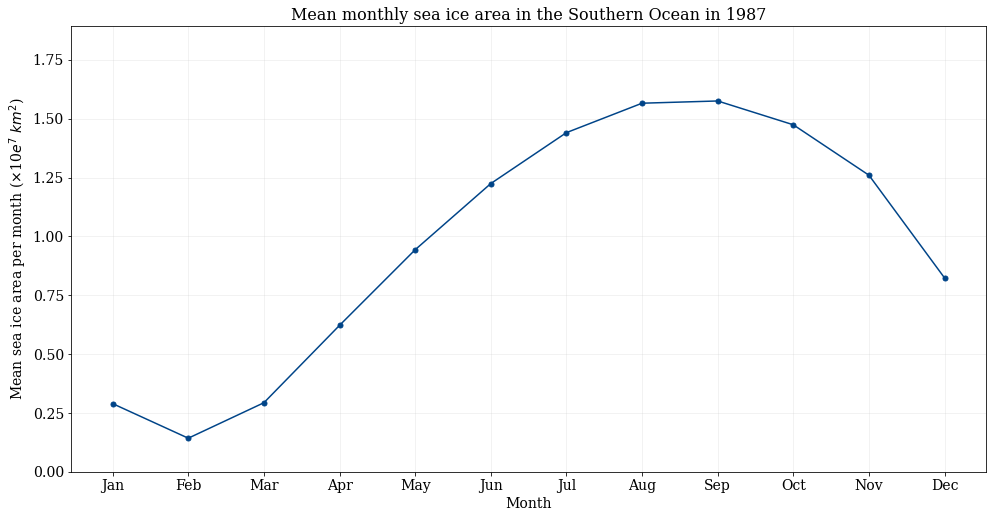

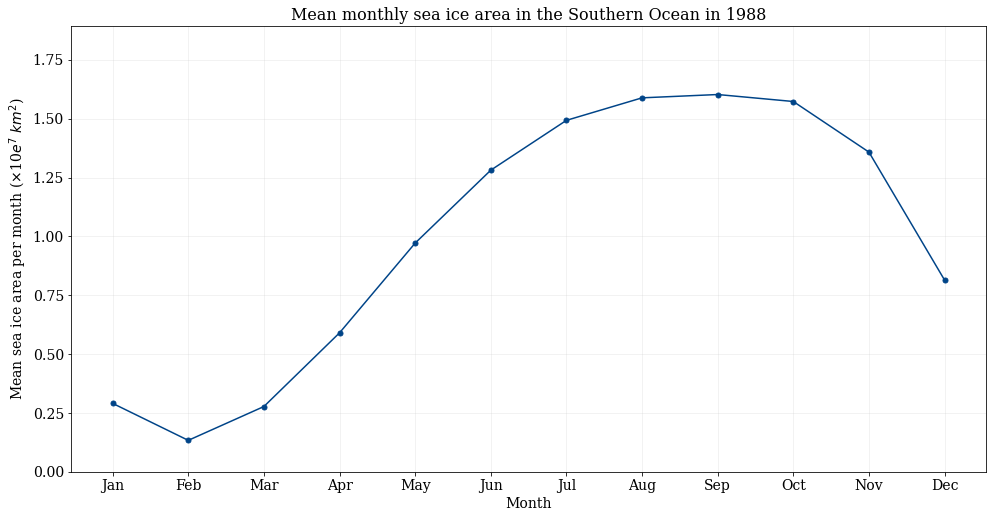

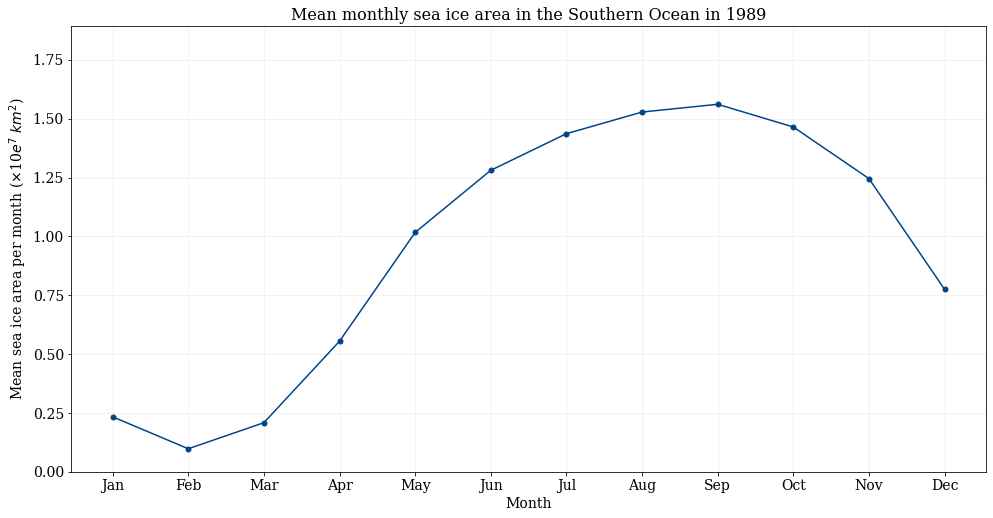

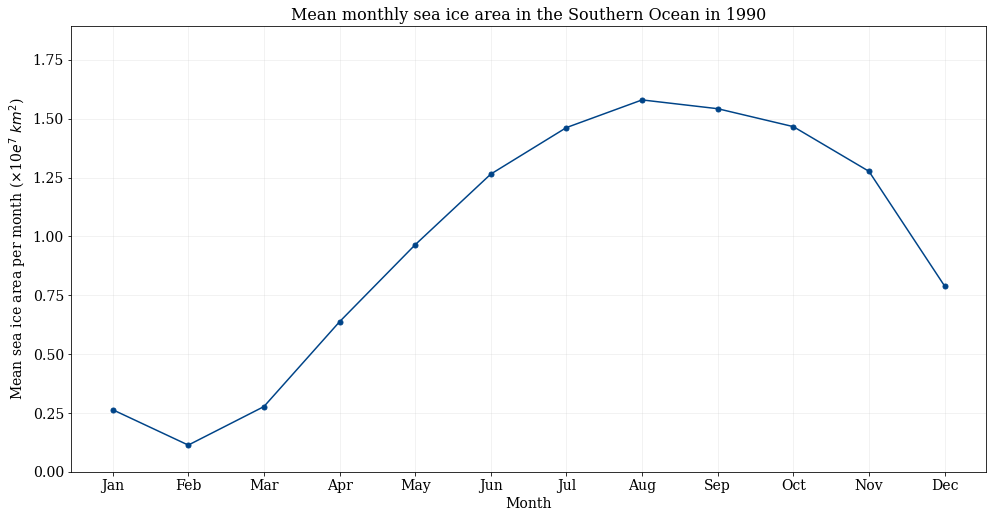

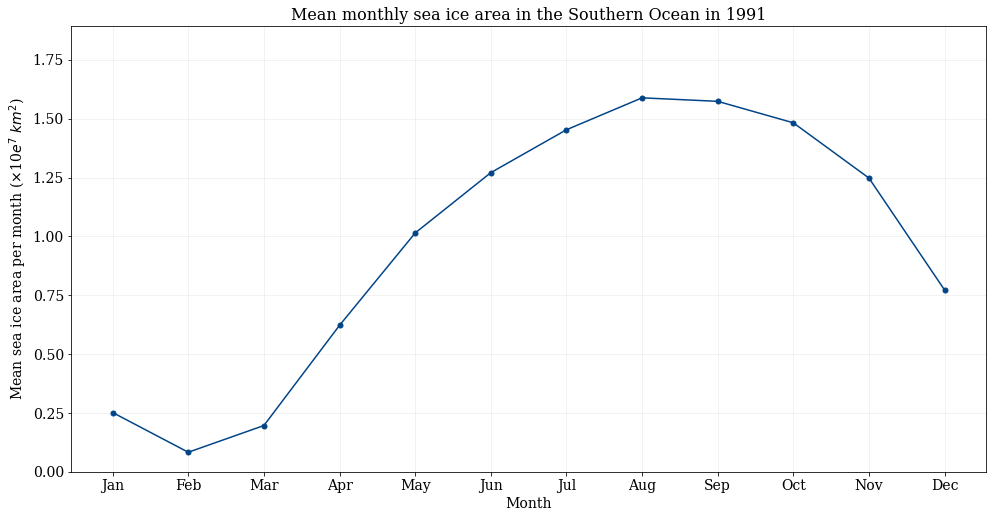

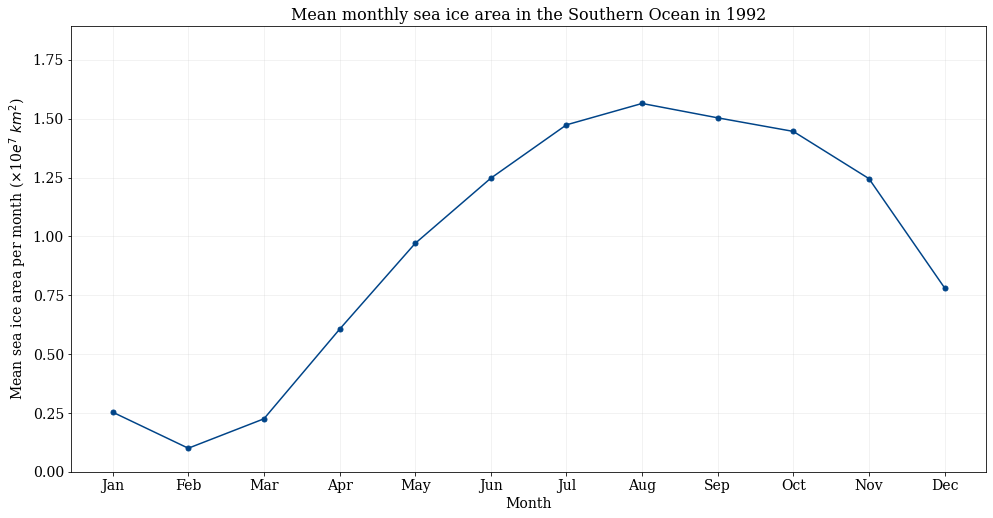

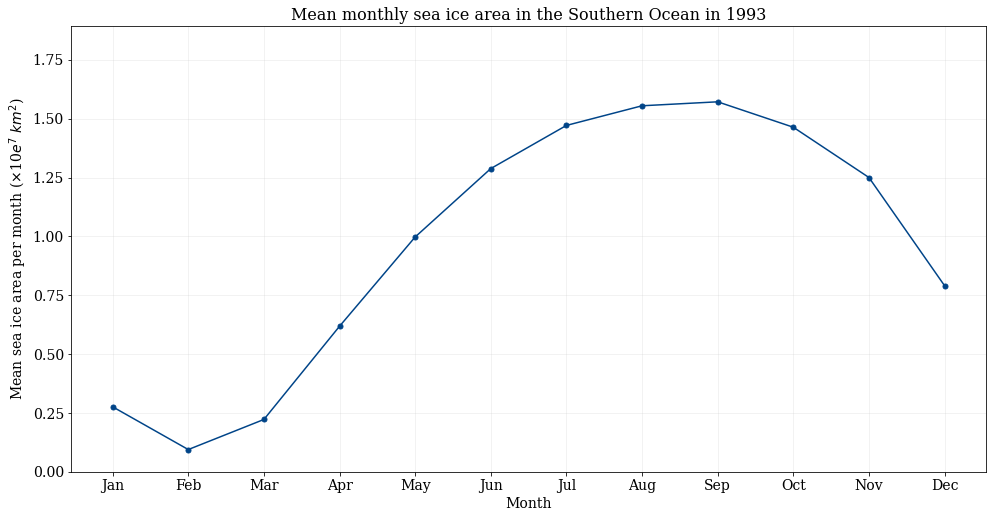

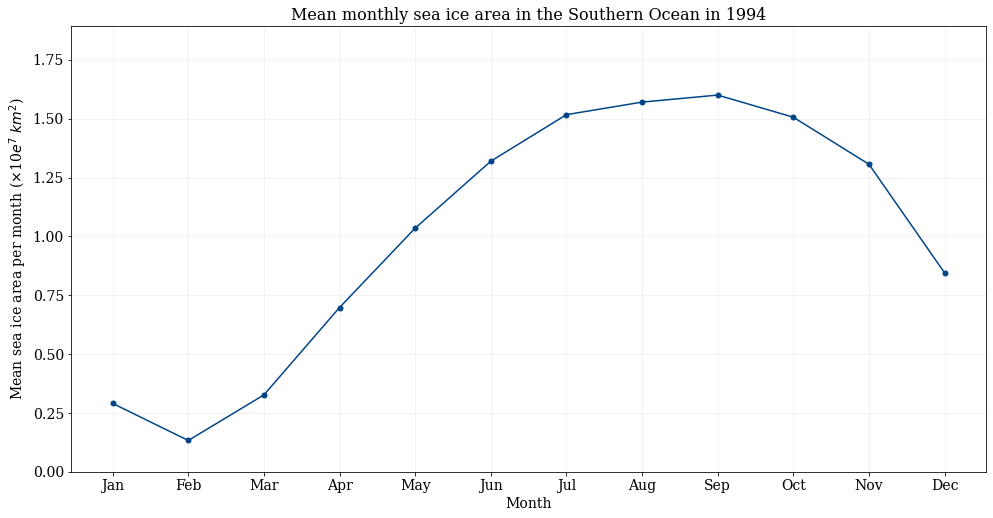

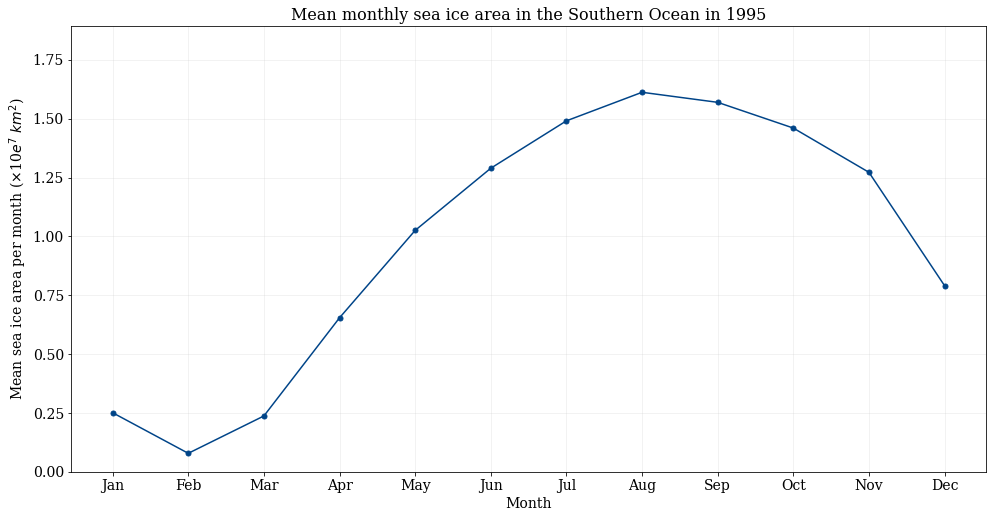

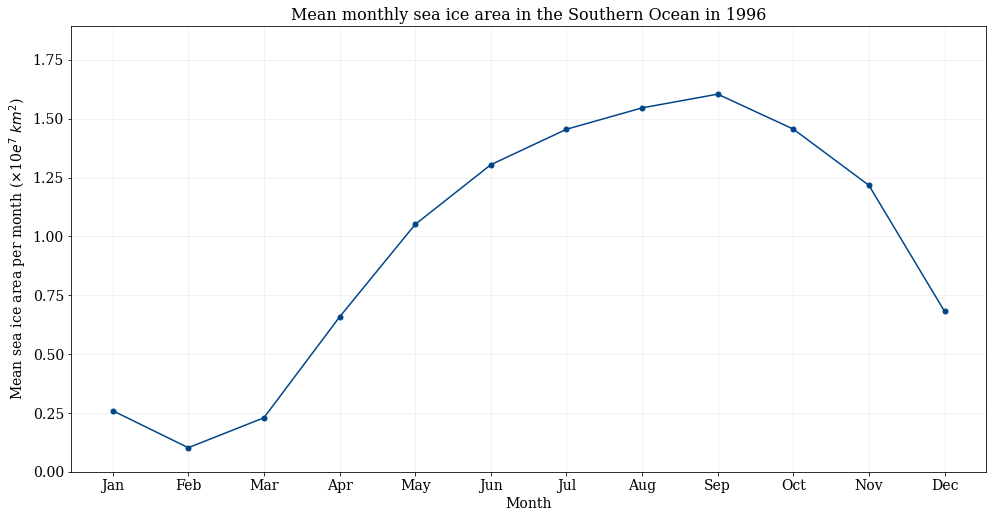

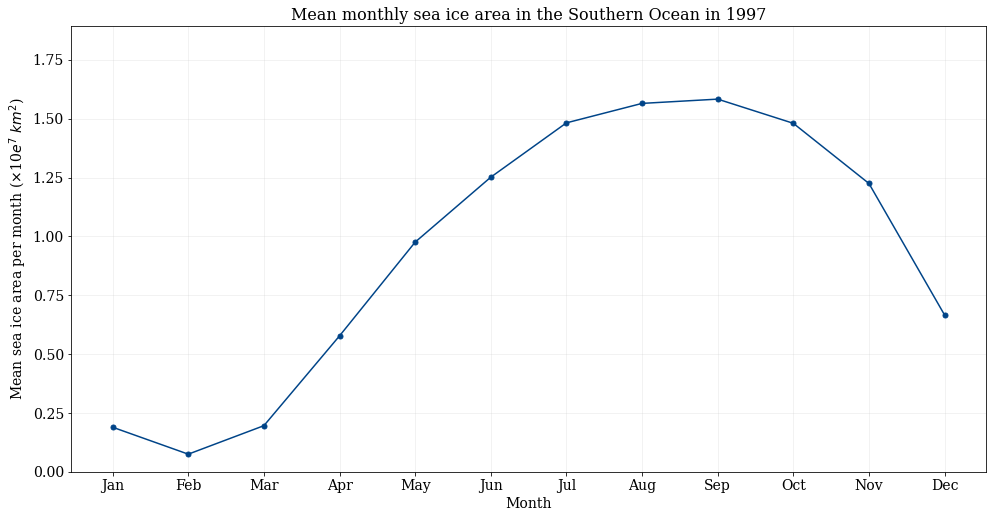

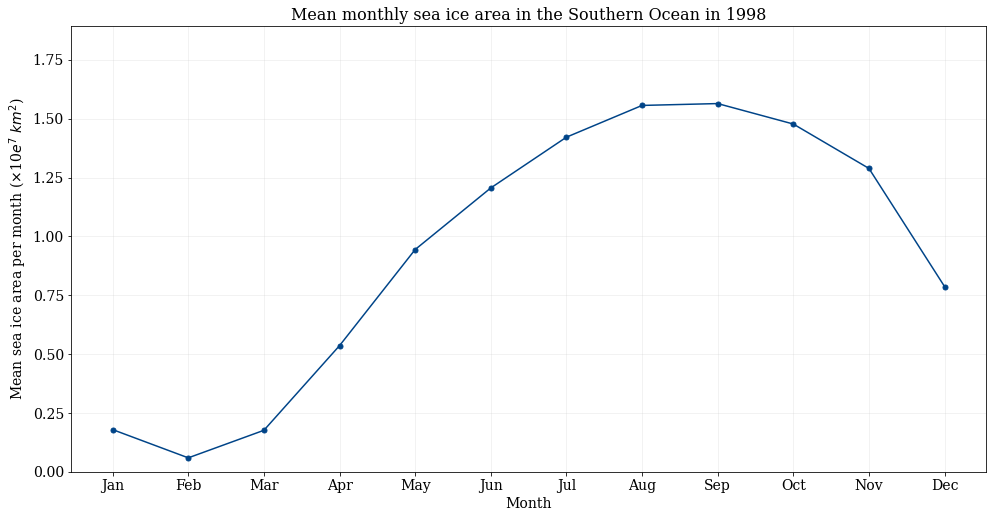

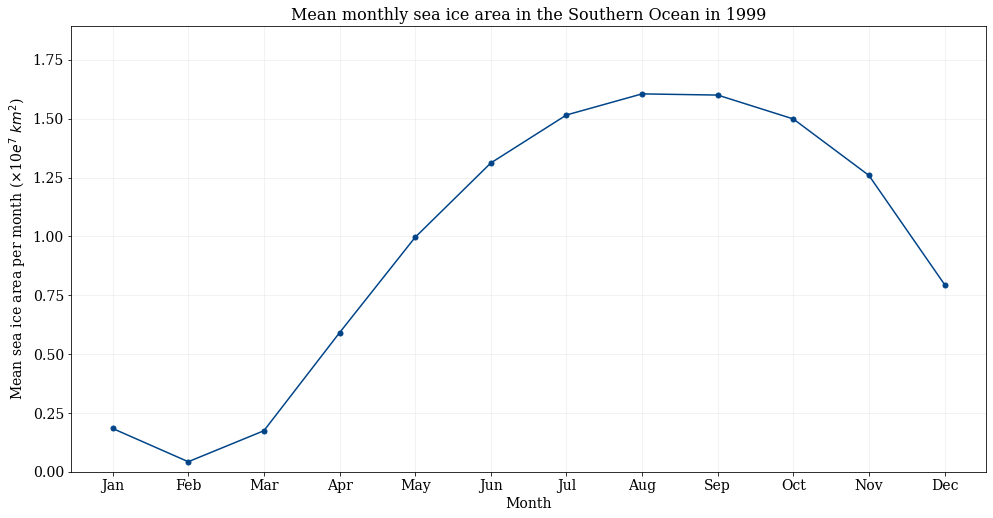

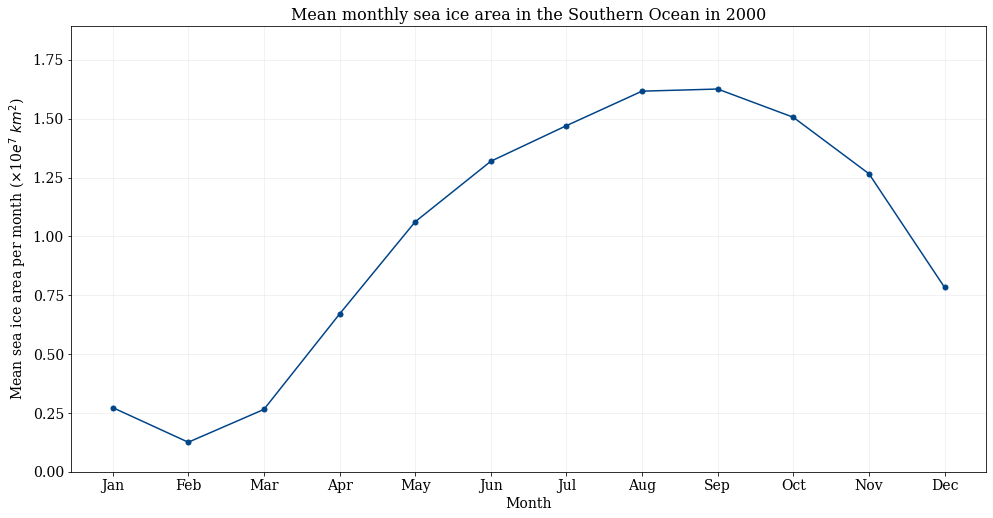

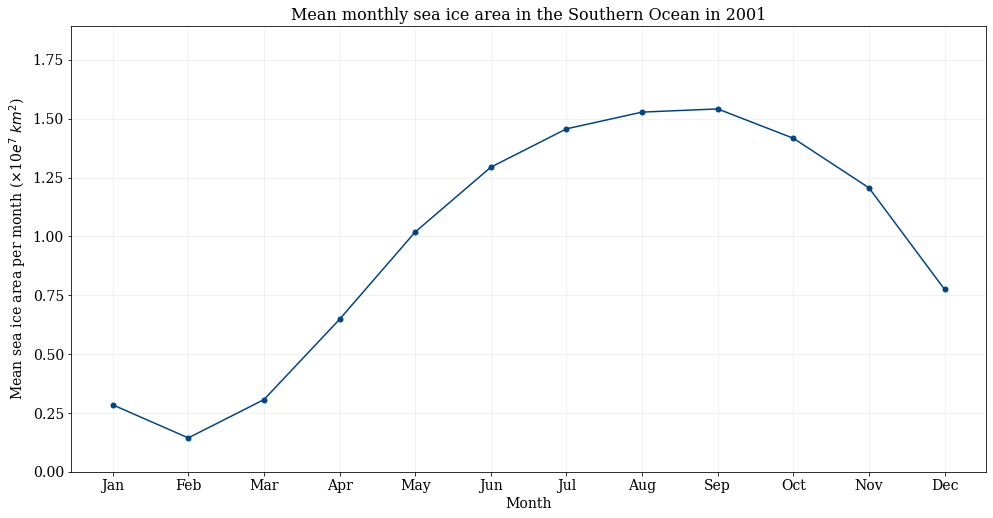

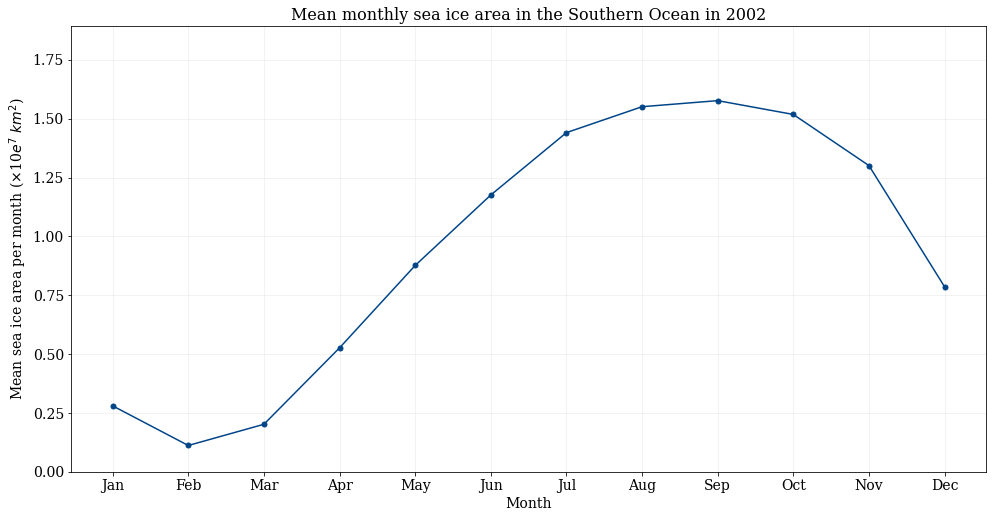

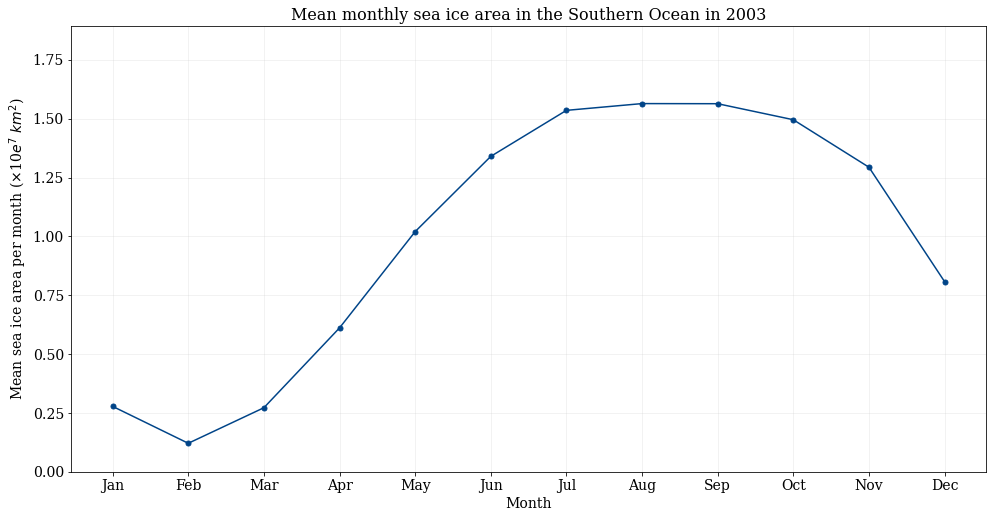

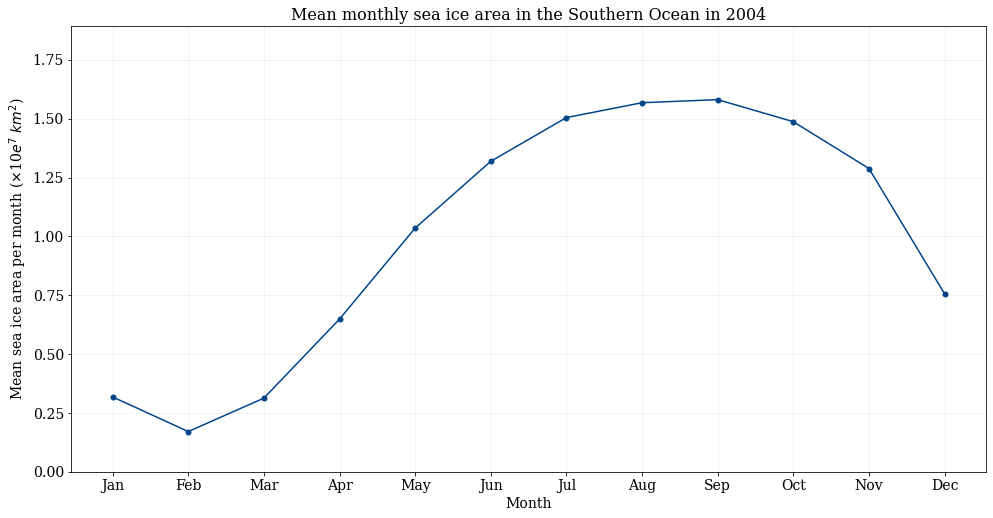

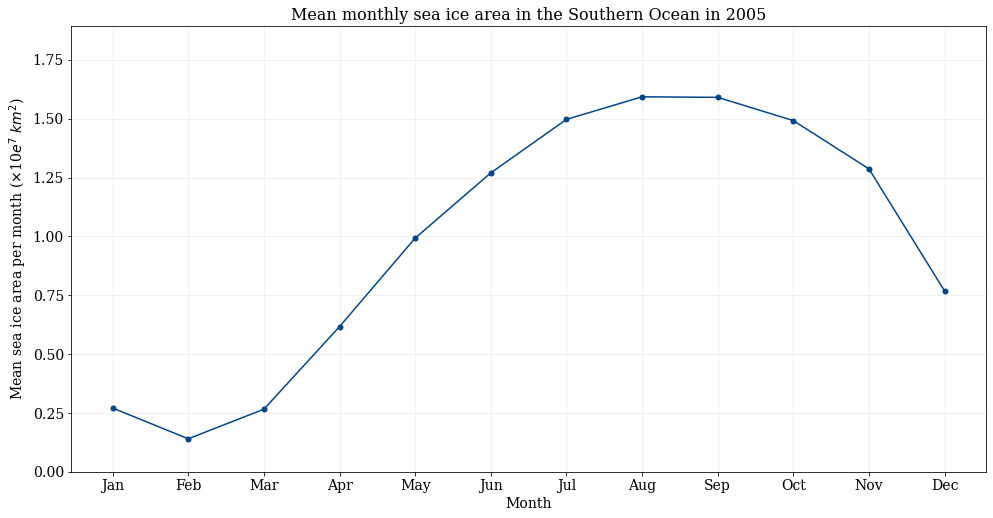

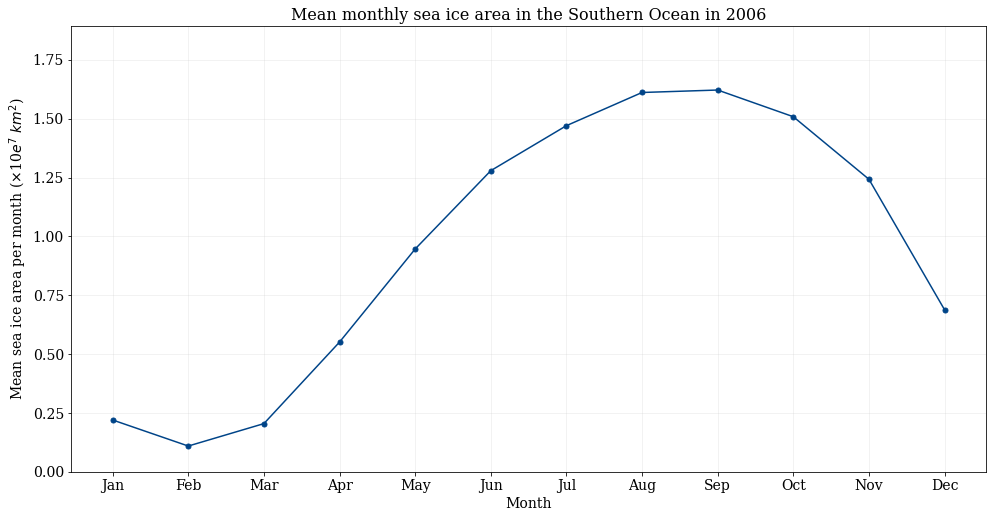

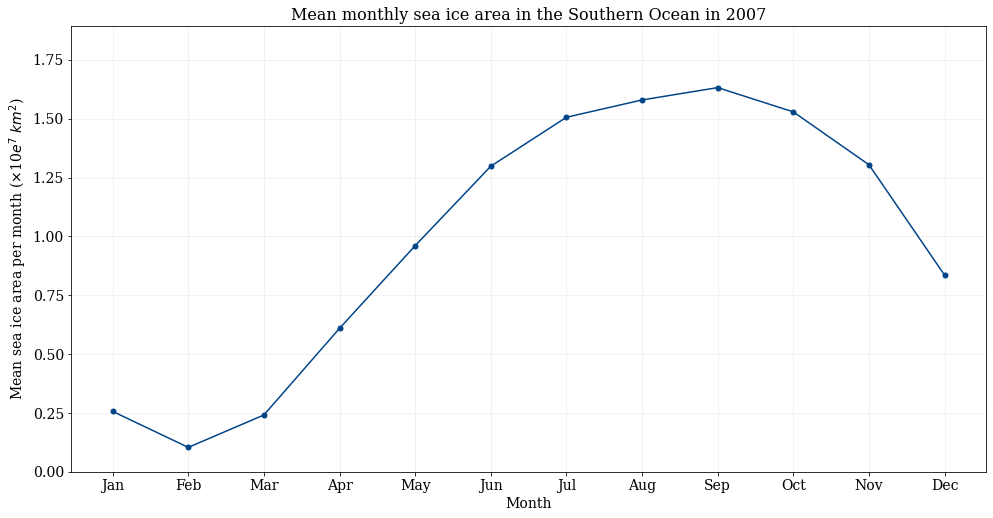

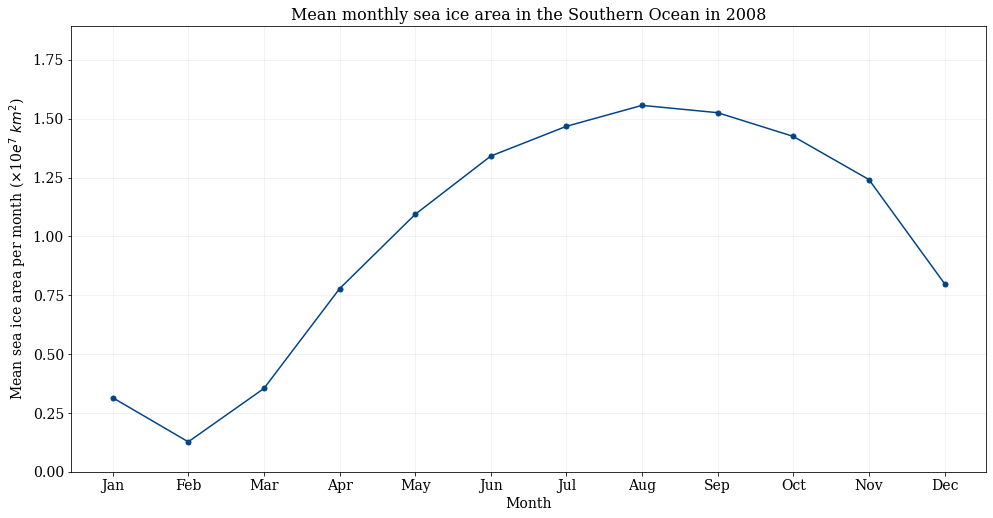

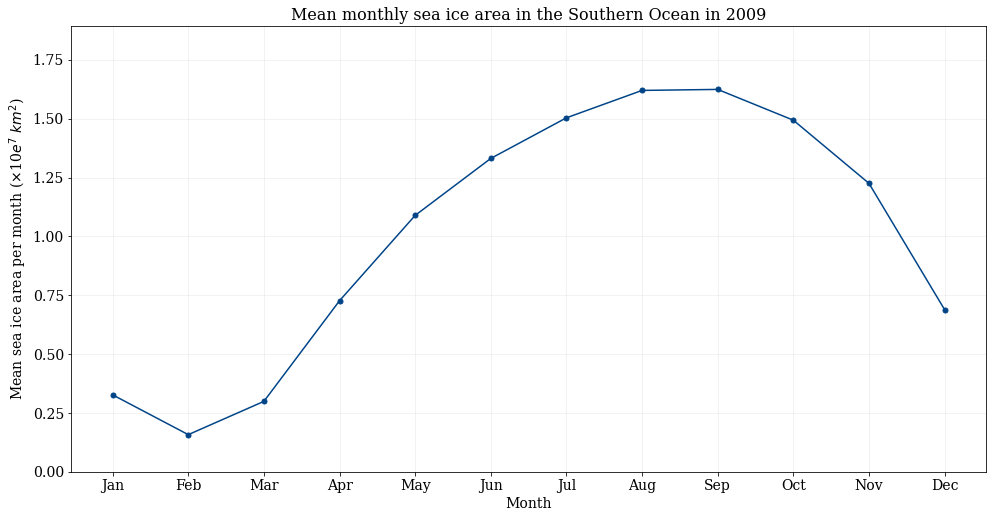

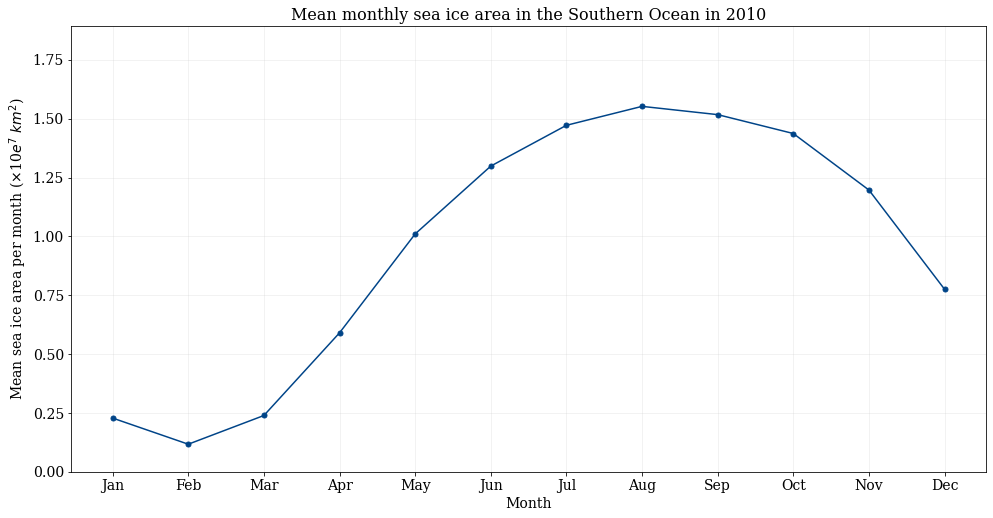

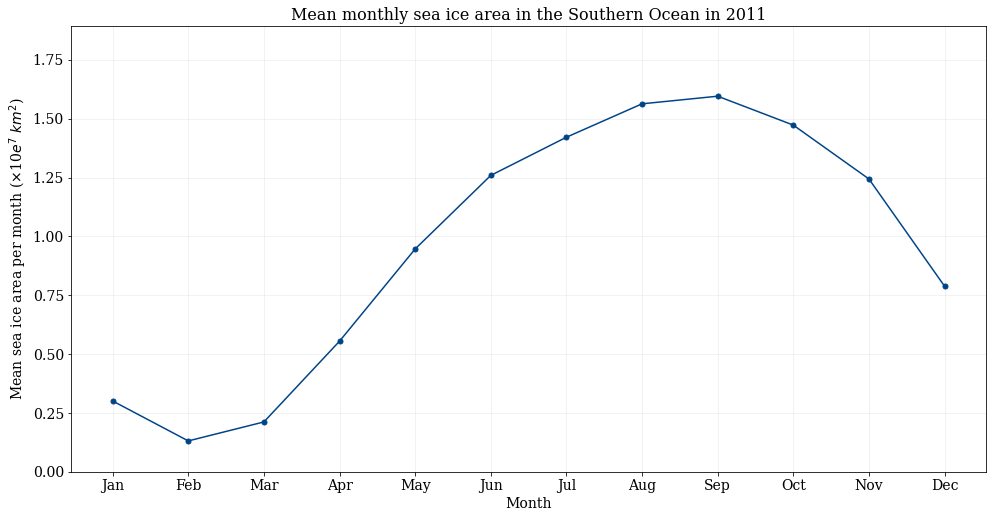

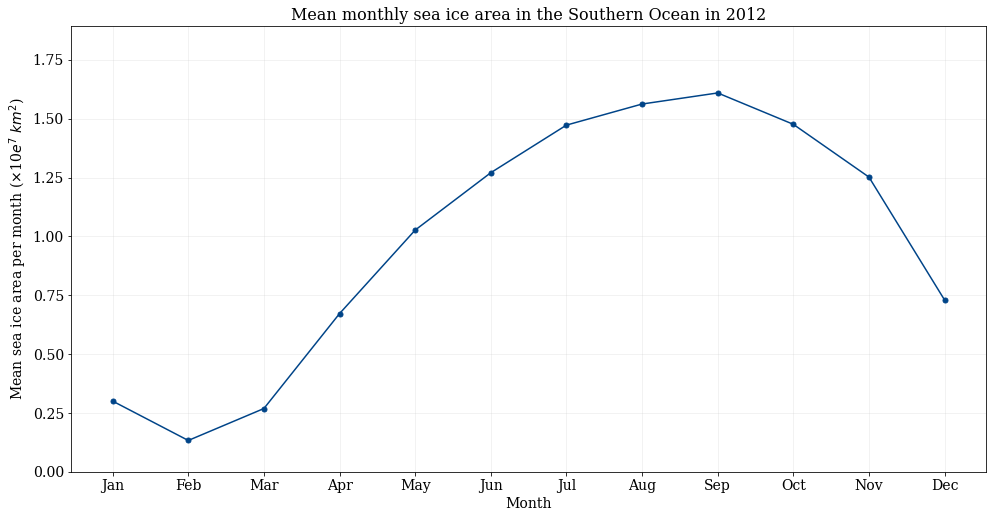

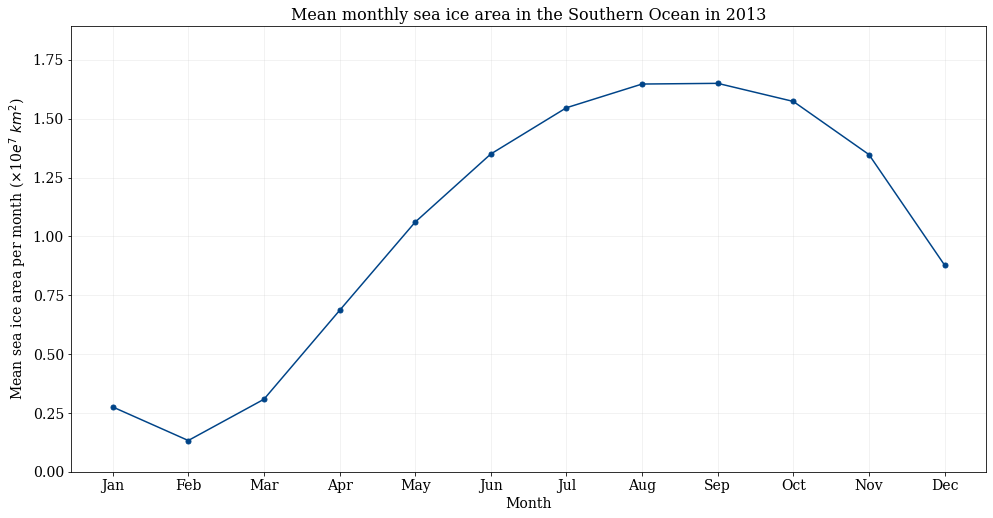

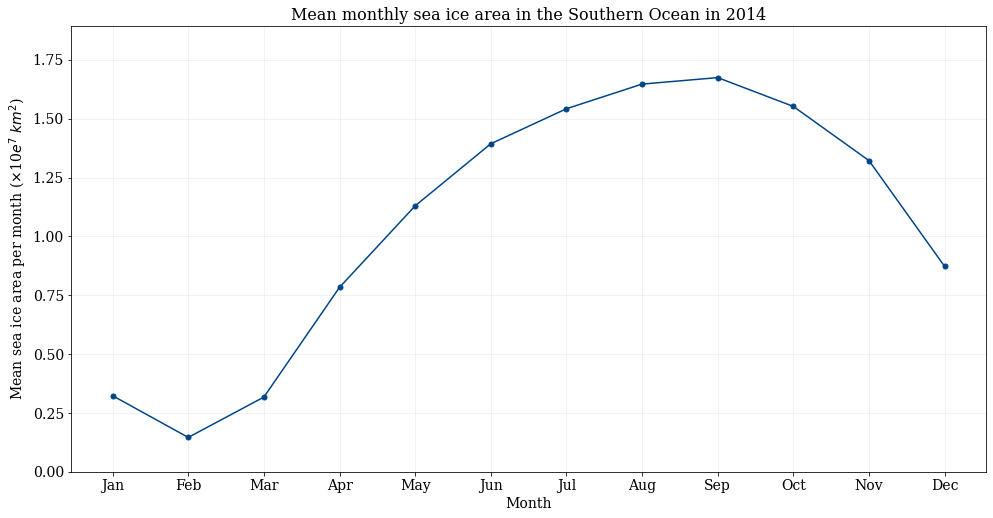

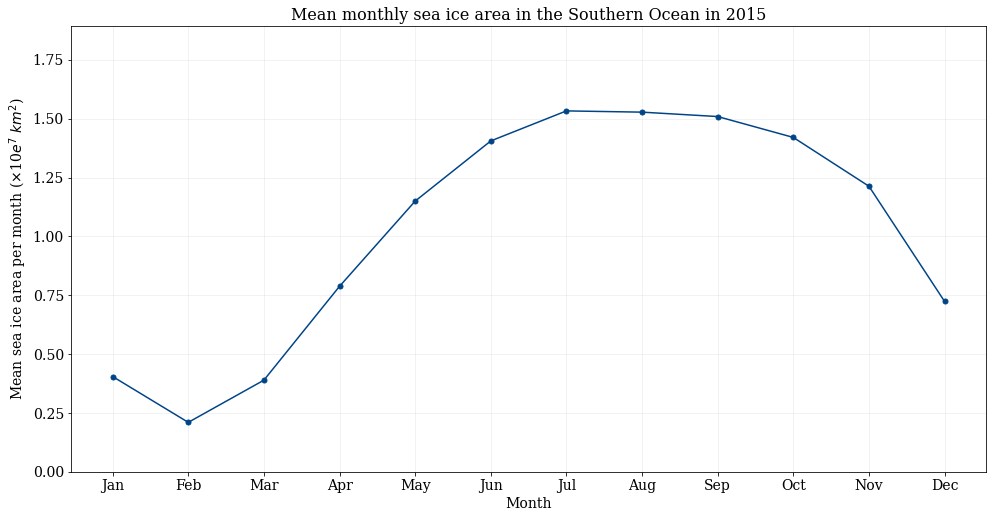

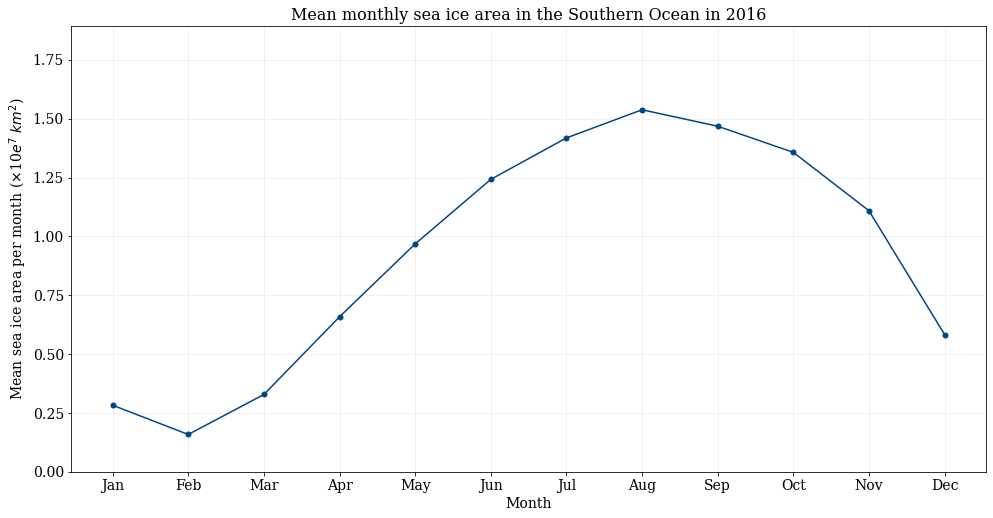

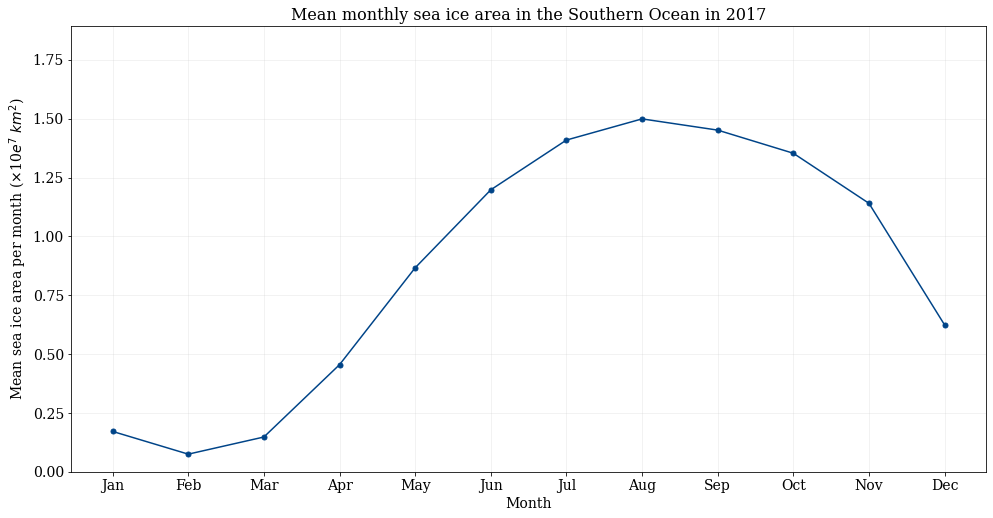

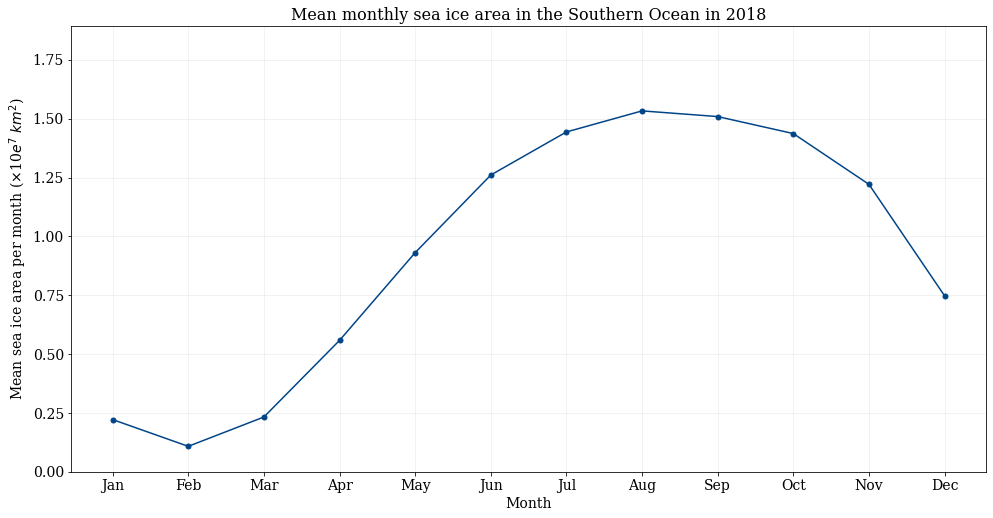

In [28]:
for i in stime:
    SOSIarea = SOIce.sel(time = i.split('-')[0])
    MonthlySeaIce(SOSIarea, max_yaxis = 18933857.8)
    SOyr = SO.sel(time = i.split('-')[0])
    SeasonalSeaIceMap(SOyr, palette = 'batlow')
    MonthlySeaIceMap(SOyr, palette = 'batlow')

In [156]:
# %who
# def myFun(arg1, **kwargs):  
#     for key, value in kwargs.items(): 
#         print ("%s == %s" %(key, value))
# tf = int(np.ceil((SO['time'].values.max().year-SO['time'].values.min().year)/10))
# tf
# intYr = SO['time'].values.min().year
# SO.sel(time = slice('2000', '2002'))
# for i in np.arange(0, tf):
#     dec = SO.sel(time = slice(str(intYr), str(intYr+10)))
#     intYr+=11
#     print(dec)
# years = np.unique([d.year for d in SO.indexes['time'].to_datetimeindex()])
# months = np.unique([d.strftime('%b') for d in SO.indexes['time'].to_datetimeindex()])
# mycolors = plt.get_cmap('tab20')
# # mycolors(5)

xr.cftime_range(start = '2005', end = '2007', freq = 'A').to_datetimeindex()
months

array(['Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May',
       'Nov', 'Oct', 'Sep'], dtype='<U3')